In [22]:
#Import necessary libraries
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import random
import numba
from numba import njit

In [23]:
# Create a class to represent letter pairs and their composite relationships
class CompositeElement:
    def __init__(self, name):
        self.name = name
        self._composite = None
    
    def composite(self):
        return self._composite
    
    def set_composite(self, other):
        self._composite = other

class CompositeMapping:
    def __init__(self):
        self.elements = {}
    
    def add_pair(self, element1, element2):
        # Create CompositeElement instances if they don't exist
        if element1 not in self.elements:
            self.elements[element1] = CompositeElement(element1)
        if element2 not in self.elements:
            self.elements[element2] = CompositeElement(element2)
        
        # Set up the composite relationship
        self.elements[element1].set_composite(self.elements[element2])
        self.elements[element2].set_composite(self.elements[element1])
    
    def get_element(self, name):
        return self.elements.get(name)





def create_mapping():# Check encoding first
    
    # Create a composite mapping
    composite_mapping = CompositeMapping()
    
    # Define all the letter sets
    latin_upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    latin_lower = 'abcdefghijklmnopqrstuvwxyz'

    
    # Define Latin names
    latin_names_upper = [
        'ALPHA', 'BETA', 'GAMMA', 'DELTA', 'EPSILON', 'ZETA', 'ETA', 'THETA',
        'IOTA', 'KAPPA', 'LAMBDA', 'MU', 'NU', 'XI', 'OMICRON', 'PI', 'RHO',
        'SIGMA', 'TAU', 'UPSILON', 'PHI', 'CHI', 'PSI', 'OMEGA'
    ]
    latin_names_lower = [name.lower() for name in latin_names_upper]

    
    
    # 1. Latin uppercase to uppercase prime
    for letter in latin_upper:
        composite_mapping.add_pair(letter, f"{letter}_prime")
    
    # 2. Latin lowercase to lowercase prime
    for letter in latin_lower:
        composite_mapping.add_pair(letter, f"{letter}_prime")
    
    
    # 5. Latin names uppercase to uppercase prime
    for name in latin_names_upper:
        composite_mapping.add_pair(name, f"{name}_prime")
    
    # 6. Latin names lowercase to lowercase prime
    for name in latin_names_lower:
        composite_mapping.add_pair(name, f"{name}_prime")

    # 7. Numbers to uppercase prime
    for number in range(1, 100):
        composite_mapping.add_pair(str(number), f"{str(number)}_prime")
    composite_mapping.add_pair('SIX','SIX')
    
    return composite_mapping


    
composite_mapping=create_mapping()

In [24]:
# Function to get the inverse composite of a sequence, takes a sequence of names and returns the corresponding composite names in reverse order

# def inverse_composite(sequence):
#     inverse_composite=sequence[::-1]
#     for i in range(len(inverse_composite)):
#         inverse_composite[i]=composite_mapping.elements[inverse_composite[i]]._composite.name
#     return inverse_composite
@njit
def inverse_composite(sequence):
    inverse_composite=sequence[::-1]
    for i in range(len(inverse_composite)):
        if inverse_composite[i].islower():
            inverse_composite[i]=inverse_composite[i].upper()
        elif inverse_composite[i].isupper():
            inverse_composite[i]=inverse_composite[i].lower()
    return inverse_composite

In [25]:
# Function to define deletion and inversion operations,takes a DNA sequence and two sites, and returns the modified sequence
@njit
def delete_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+DNA[site_2:]  
@njit
def invert_between(DNA,site_1,site_2):
    return DNA[:site_1-1]+inverse_composite(DNA[site_1-1:site_2])+DNA[site_2:] 

In [26]:
# Functions to detect sites in a DNA sequence, takes a DNA sequence and a site, and returns the start positions of the sites and the direction (forward or backward)
@njit
def detect_pair_BRA(DNA,site):
    site_length = len(site)
    start_positions = []
    
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        DNA_window=DNA[i:i+site_length]
        if DNA_window == site:
            start_positions.append((i,'forward'))#computer positions
        elif DNA_window == inverse_composite(site):
            start_positions.append((i,'backward'))#computer positions

    
    return start_positions
@njit
def detect_pair_KET(DNA,site):
    site_length = len(site)
    start_positions = []
    
    # Slide through the DNA looking for matches
    for i in range(len(DNA) - site_length + 1):
        # Check if current window matches the site
        DNA_window=DNA[i:i+site_length]
        if DNA_window == site:
            start_positions.append((i,'forward'))#computer positions
        elif DNA_window == inverse_composite(site):
            start_positions.append((i,'backward'))#computer positions
    
    return start_positions


In [27]:
# Function to evaluate the colour of a DNA sequence based on two choices, takes a DNA sequence and two choices (each with a number and direction) and returns the modified sequence

def evaluate_colour_IS110(DNA,choice1,choice2):

    num1, direction_1 = choice1
    num2, direction_2 = choice2
    #WLOG,make num 1 the smaller one
    if num1 > num2:
        num1, num2 = num2, num1
        direction_1, direction_2 = direction_2, direction_1
    # Determine which function to use
    
    if direction_1 == 'forward':
        if direction_1 == direction_2:
            result= delete_between(DNA,num1+2,num2+1)
        elif direction_1!=direction_2:
            result= invert_between(DNA,num1+2,num2+1)
    elif direction_1=='backward':
        if direction_1 == direction_2:
            result= delete_between(DNA,num1+2,num2+1)
        else :
            #result= 'DoNotCount'
            result= invert_between(DNA,num1+2,num2+1)
    if choice1==choice2:
        result='DoNotCount'
    return result

In [28]:
# Function to calculate the probabilities of different outcomes based on a DNA sequence and a pool of pairs
# Takes a DNA sequence, a pool of pairs, and the number of events, and returns a list called 'outcome_lists' containing Counters object that record the probabilities for each stage of the process

In [29]:
# ***What an outcome list looks like***


# [Counter({('1',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4',
#            'ALPHA_prime',
#            'A_prime'): 1}),

#  Counter({('1',
#            'A',
#            'ALPHA',
#            '2_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4',
#            'ALPHA_prime',
#            'A_prime'): 0.2,
#           ('1', 'A', 'ALPHA', '4', 'ALPHA_prime', 'A_prime'): 0.2,
#           ('1',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3_prime',
#            'A',
#            'ALPHA',
#            '2_prime',
#            'ALPHA_prime',
#            'A_prime'): 0.2,
#           ('1', 'A', 'ALPHA', '2', 'ALPHA_prime', 'A_prime'): 0.2,
#           ('1',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime'): 0.2}),
           
#  Counter({('1', 'A', 'ALPHA', '2_prime', 'ALPHA_prime', 'A_prime'): 0.28,
#           ('1', 'A', 'ALPHA', '4_prime', 'ALPHA_prime', 'A_prime'): 0.28,
#           ('1',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime',
#            '3',
#            'A',
#            'ALPHA',
#            '4',
#            'ALPHA_prime',
#            'A_prime'): 0.12,
#           ('1',
#            'A',
#            'ALPHA',
#            '4_prime',
#            'ALPHA_prime',
#            'A_prime',
#            '3_prime',
#            'A',
#            'ALPHA',
#            '2',
#            'ALPHA_prime',
#            'A_prime'): 0.08})]

In [30]:
#Calculate the possibe DNA sequences follwing one recombinases event from one input
def calculate_each_input(dna, pairs_pool, print_output=0, print_T=0):
    """
    Parameters:
    dna (list): The DNA sequence represented as a list of names.
    pairs_pool (list): A list of pairs of sites to be processed.
    print_output (int): If 1, print the output for each recombinase action.
    print_T (int): If 1, print a message when a terminal state is reached.
    
    Returns:
    tuple: A tuple containing the result Counter and the normalization factor.
    """
    thisinput = Counter()
    recombinase_acted = 0
    for pair in pairs_pool:
        #print(pair)
        BRA_sites=pair[0]
        KET_sites=pair[1]

        BRA_positions=detect_pair_BRA(dna,BRA_sites)
        KET_positions=detect_pair_KET(dna,KET_sites)

        
        for i in range(len(BRA_positions)):
            for j in range(len(KET_positions)):
                choice1,choice2 = BRA_positions[i], KET_positions[j]
                #print(choice1,choice2)
                output = evaluate_colour_IS110(dna,choice1,choice2)
                formatted_output = tuple(output)
                if print_output==1:
                    
                    print(formatted_output)
                if output!='DoNotCount':
                    recombinase_acted += 1
                    

                    #print(f"stage {whichstage} dna {dna} recombinase {recombinase_acted} output: {formatted_output}")  # !!!Remove before flight

                    thisinput[formatted_output] +=1
        #print(recombinase_acted)
    if recombinase_acted==0:
            normfactor = 1
            thisinput[tuple(dna)] = 1
            if print_T==1:
                print(tuple(dna), "Terminal state reached, no recombinase acted")
    else:
            normfactor = recombinase_acted
    return thisinput, normfactor

In [31]:
#Iterate through the DNA sequences at each stages and calculate the result 
def probability_calculation_IS110(DNA,pairs_pool,numberofevents=1,print_output=0,print_T=0):
    outcome_list=[]

    for _ in range(numberofevents):
        outcome_list.append(Counter())
    

    outcome_list[0][tuple(DNA)] = 1

    # Iterate through each stage and calculate the outcomes
    for whichstage in range(1,numberofevents):

        stage = outcome_list[whichstage-1]
        for dna,probs in stage.items():
            dna=list(dna)
            # Now work out all the things the recombinases can do
            thisinput, normfactor=calculate_each_input(dna, pairs_pool, print_output, print_T)
                
            for key in thisinput:
                outcome_list[whichstage][key] += thisinput[key]*probs/normfactor

    # Check to see if normalisation is preserved
        #print(f"Stage {whichstage} has {len(outcome_list[whichstage])} outcomes")
    return outcome_list
    


In [32]:
# Visualisation function to plot ranked probability distributions after each recombination event


def plot_ranked_probabilities(outcome_list):
    for stage in range(len(outcome_list)):
        probs = np.array(sorted(outcome_list[stage].values(), reverse=True))
        ranks = np.arange(1, len(probs) + 1)
        
        # Create a single figure with 1 row and 3 columns of subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 4))
        fig.suptitle(f'Stage {stage}: Ranked Probabilities', y=1.05)
        
        # Plot 1: Linear scale
        axes[0].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[0].set_xlabel('Rank')
        axes[0].set_ylabel('Probability')
        axes[0].set_yscale('linear')
        axes[0].set_title('Linear Scale')
        
        # Plot 2: Log-y scale
        axes[1].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[1].set_xlabel('Rank')
        axes[1].set_ylabel('Probability')
        axes[1].set_yscale('log')
        axes[1].set_title('Log-Y Scale')
        
        # Plot 3: Log-log scale
        axes[2].plot(ranks, probs, marker='o', linestyle='-', color='b')
        axes[2].set_xlabel('Rank')
        axes[2].set_ylabel('Probability')
        axes[2].set_yscale('log')
        axes[2].set_xscale('log')
        axes[2].set_title('Log-Log Scale')
        
        plt.tight_layout()
        plt.show()

In [33]:
# Visualisation function to plot the probabilities sum and entropy of outcomes at each stage
def plot_probabilities(outcome_list, numberofevents=1,rank=0):    
    probsum = 0
    num_of_possible_outcomes = np.zeros(numberofevents)
    total_num_of_outcomes = np.zeros(numberofevents)
    entropy = np.zeros(numberofevents)
    initial_dict=Counter()
    for stage in range(numberofevents):
        probsum = np.sum(list(outcome_list[stage].values()))
        if (probsum-1)> 0.01 or (probsum-1)<-0.01:
            raise ValueError(f"Stage {stage} does not sum to 1, it sums to {probsum}. Please check the input data or the calculation logic.")
        entropy[stage] = -np.sum([p * np.log2(p) for p in outcome_list[stage].values() if p > 0])
        num_of_possible_outcomes[stage] = len(outcome_list[stage])
        initial_dict.update(outcome_list[stage])
        total_num_of_outcomes[stage] = len(initial_dict)

    # # Plot normalisation
    # plt.figure(figsize=(6, 3))
    # plt.plot(probsum, marker='o', linestyle='-', color='k')
    # plt.xlabel('Stage')
    # plt.ylabel('Sum of Probabilities')
    # #plt.ylim(0, 1.1)

    # Plot number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(num_of_possible_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Number of Possible Outcomes occuring at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot cumulative number of possible outcomes
    plt.figure(figsize=(6, 3))
    plt.plot(total_num_of_outcomes, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Cumulative number of Possible Outcomes at Each Stage')
    #plt.ylim(0, np.max(num_of_possible_outcomes) * 1.1)

    # Plot entropy
    plt.figure(figsize=(6, 3))
    plt.plot(entropy, marker='o', linestyle='-', color='k')
    plt.xlabel('Stage')
    plt.ylabel('Entropy')
    #plt.ylim(0, np.max(entropy) * 1.1)

    # Plot ranked probabilities
    plot_ranked_probabilities(outcome_list) if rank==1 else None

    


In [34]:
#A function that packs the probability calculation and plotting functions together, takes a DNA sequence, a pool of pairs, and the number of events, and returns the outcome lists
def run_probability_calculation_and_plot_IS110(DNA_sequence, pairs_pool, numberofevents=1, print_output=0, print_T=0,rank=0,plot=0):
    outcome_list = probability_calculation_IS110(DNA_sequence, pairs_pool, numberofevents, print_output, print_T)
    plot_probabilities(outcome_list, numberofevents,rank=rank) if plot==1 else None
    return outcome_list

C:\Users\Thoma\AppData\Local\Temp\ipykernel_20320\56849583.py:14: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sequence' of function 'inverse_composite'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\AppData\Local\Temp\ipykernel_20320\2432043843.py", line 8:
<source missing, REPL/exec in use?>

  elif DNA_window == inverse_composite(site):
c:\Users\Thoma\anaconda3\envs\rstudio\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'DNA' of function 'detect_pair_BRA'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\AppData\Local\Temp\ipykernel_20320\5

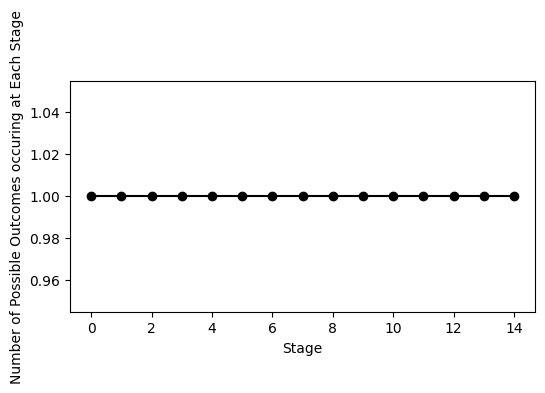

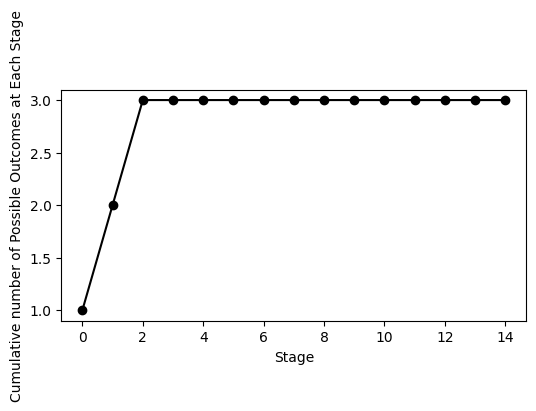

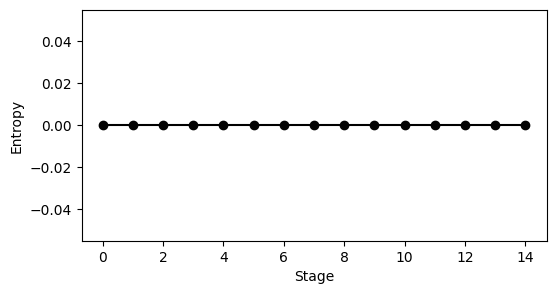

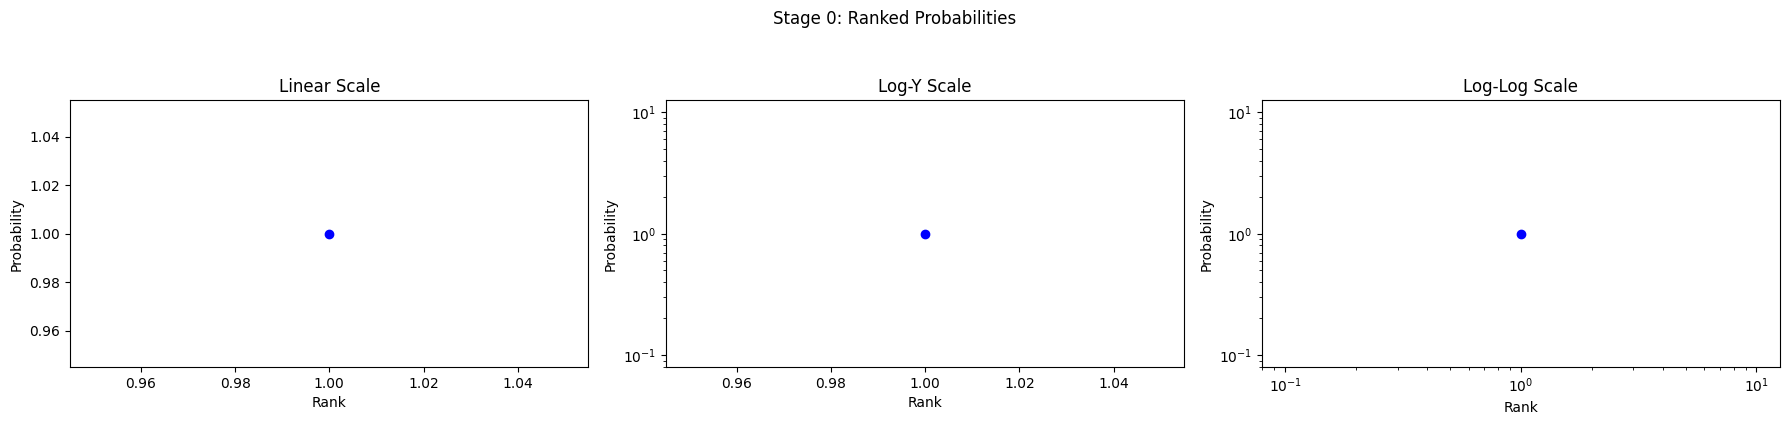

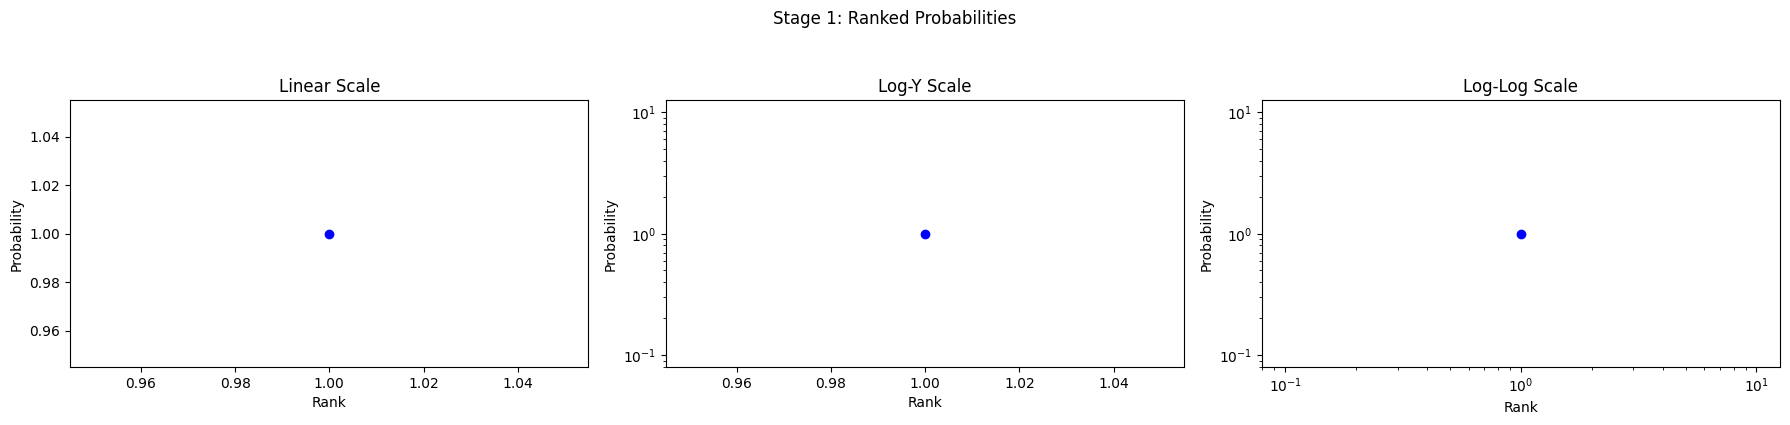

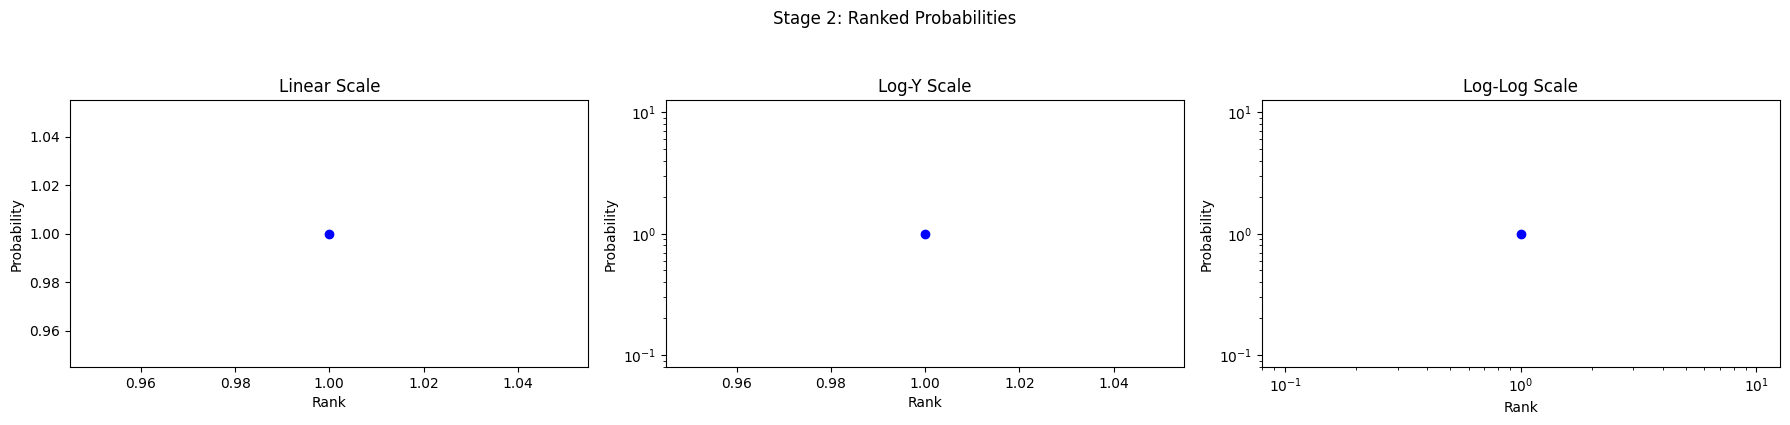

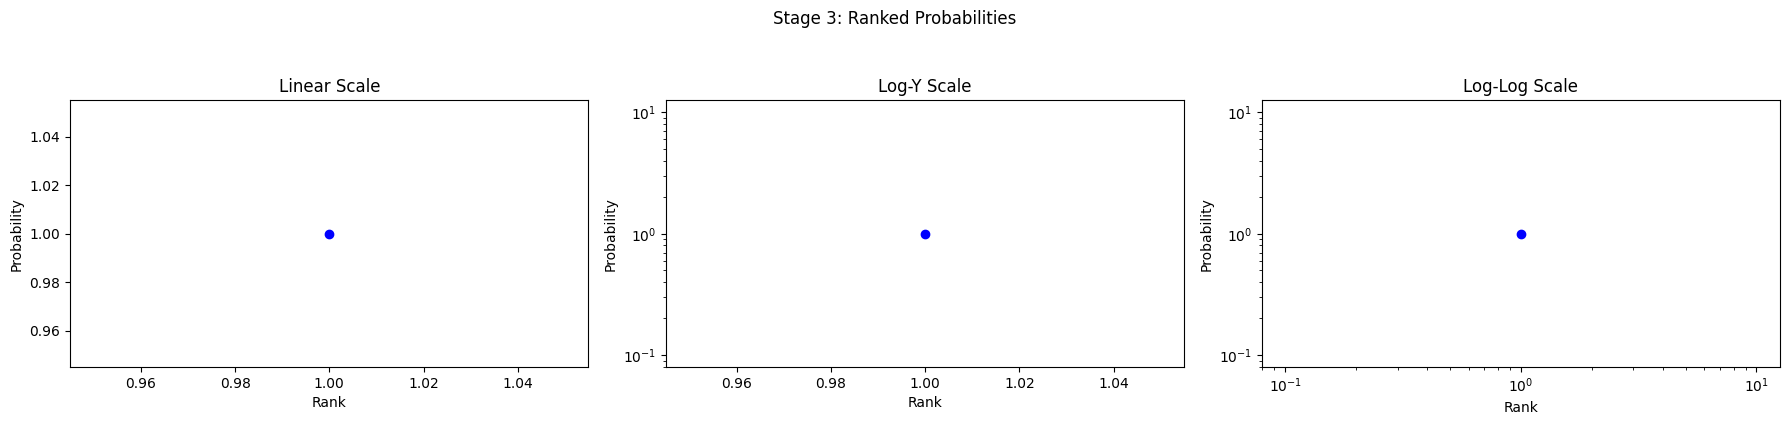

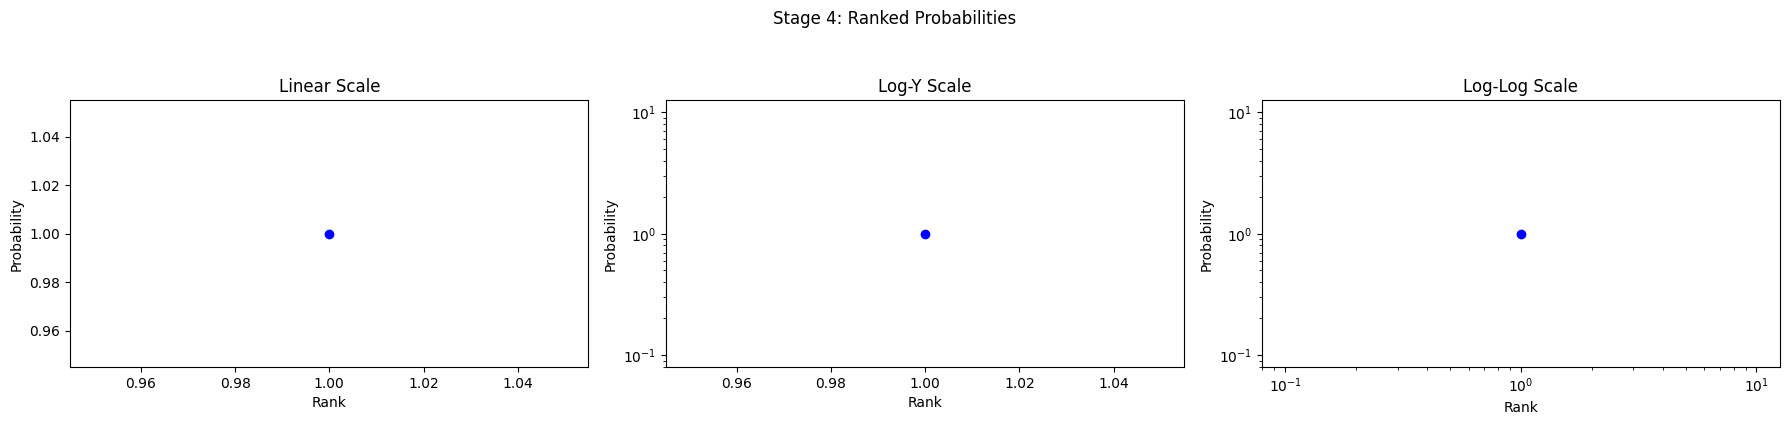

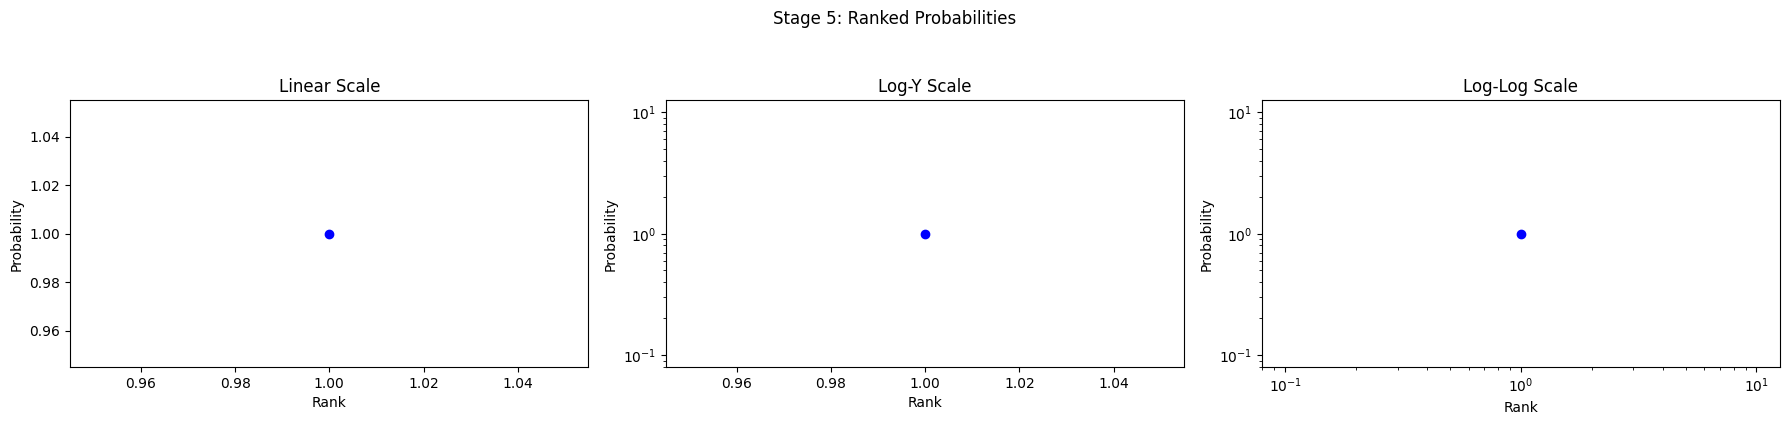

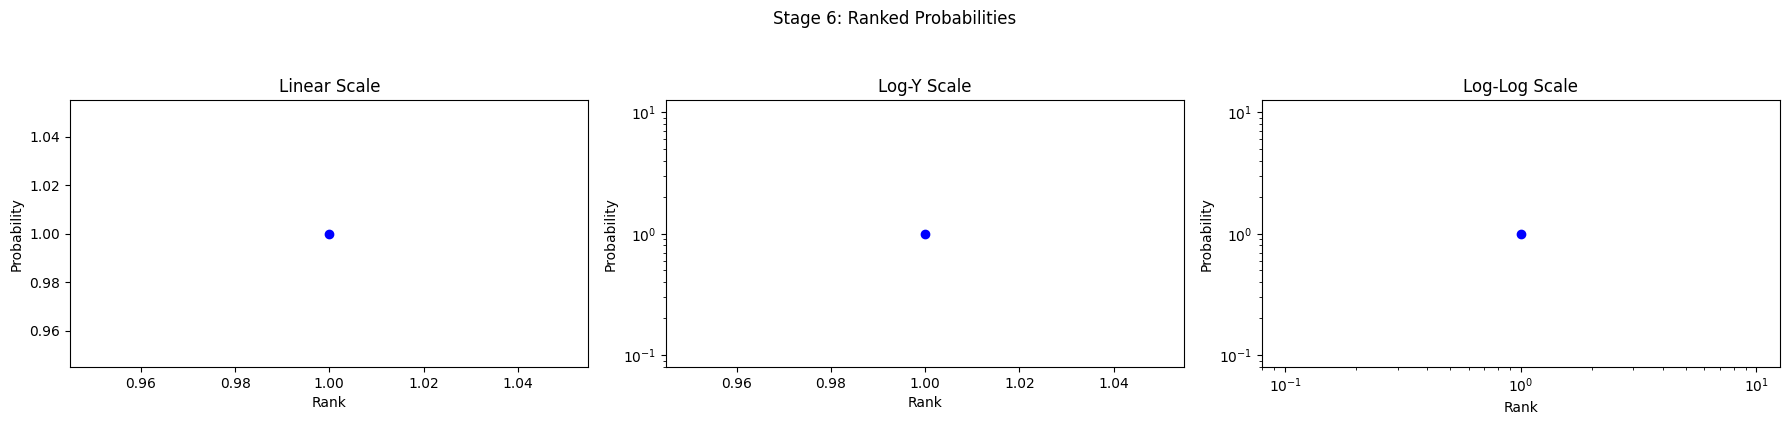

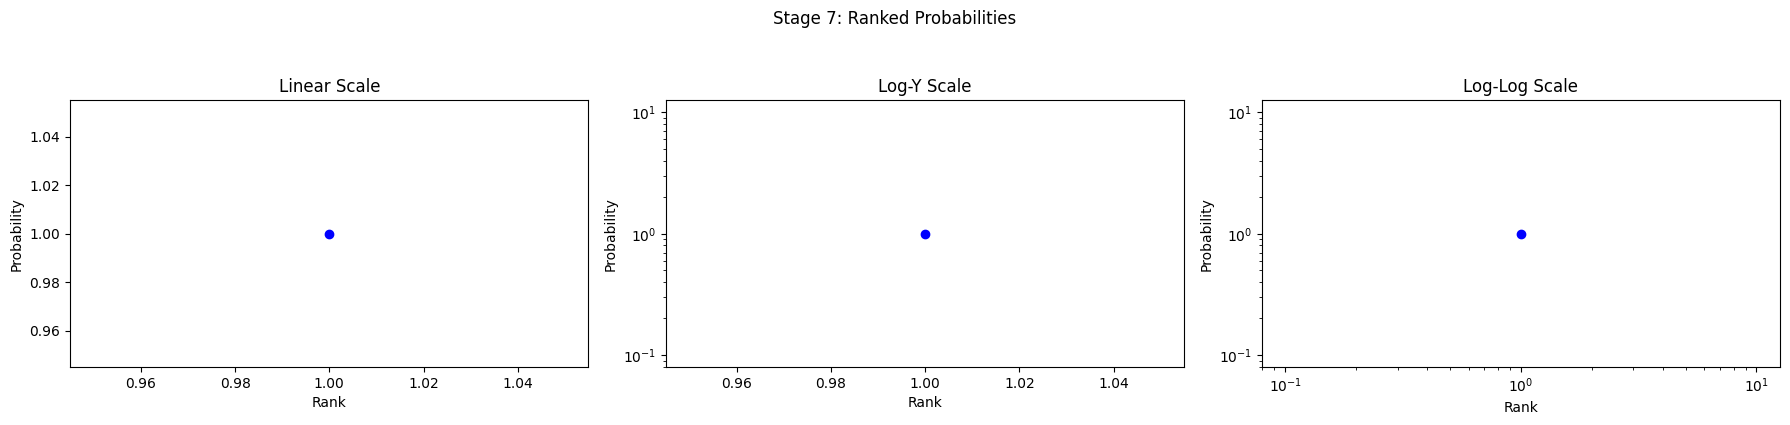

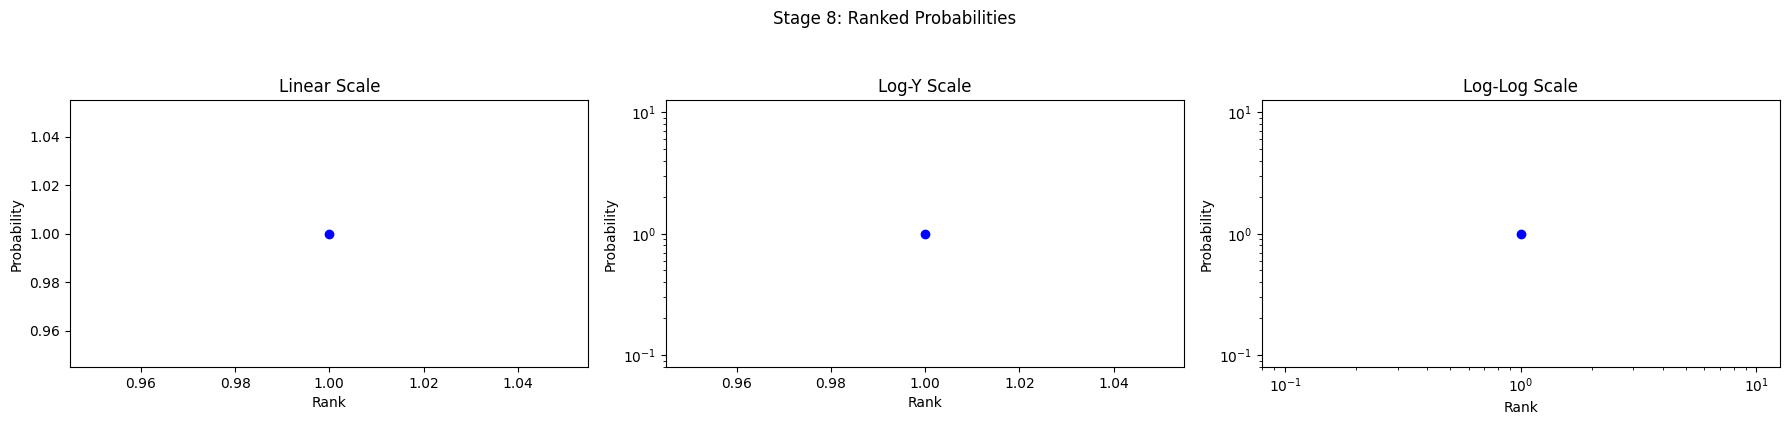

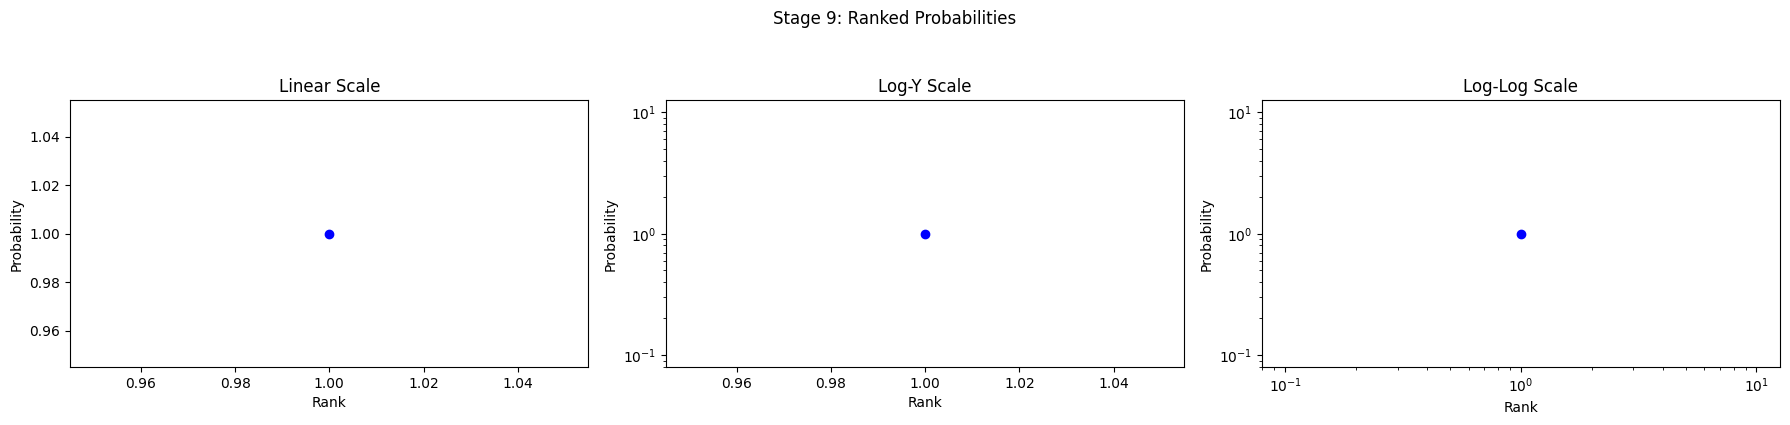

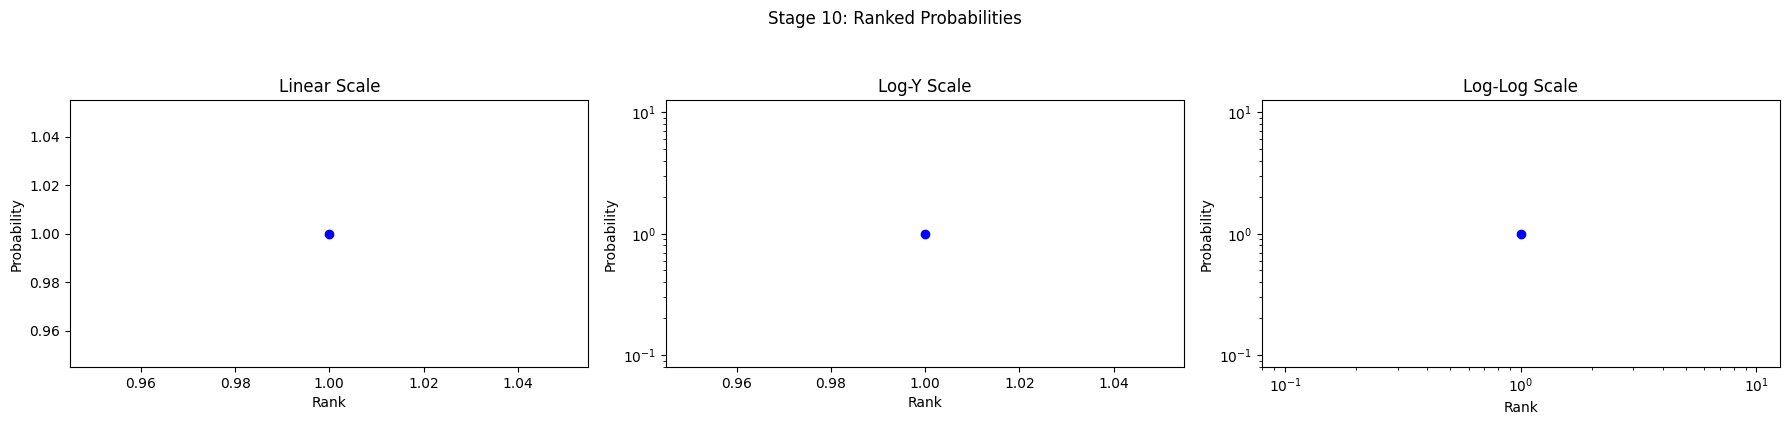

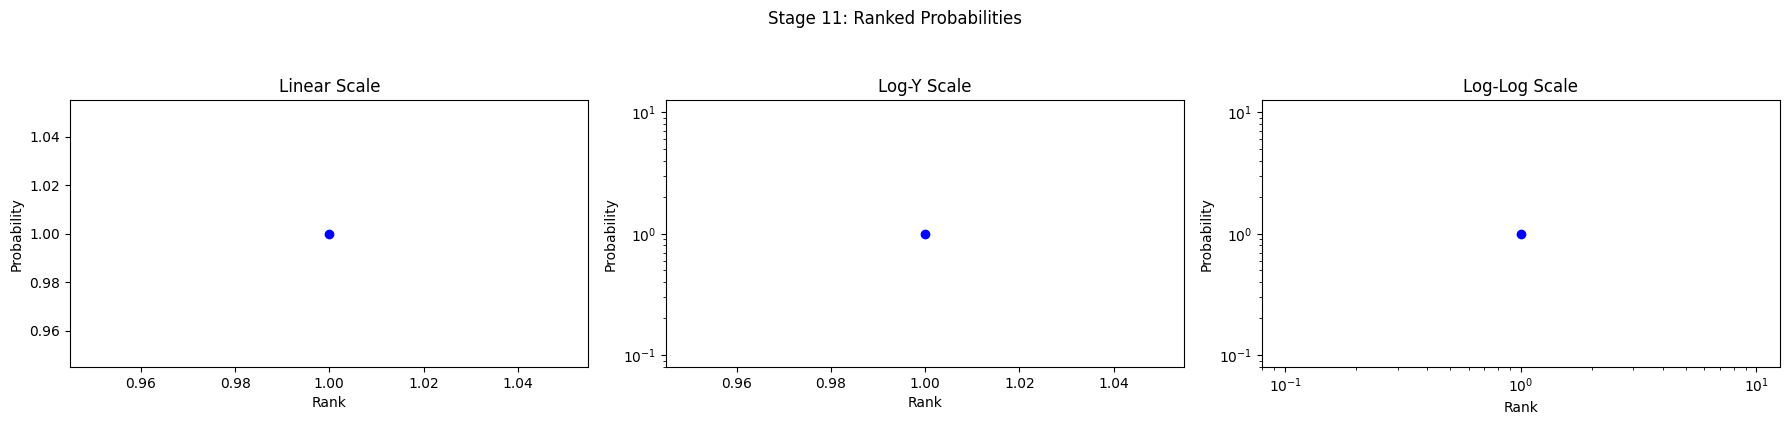

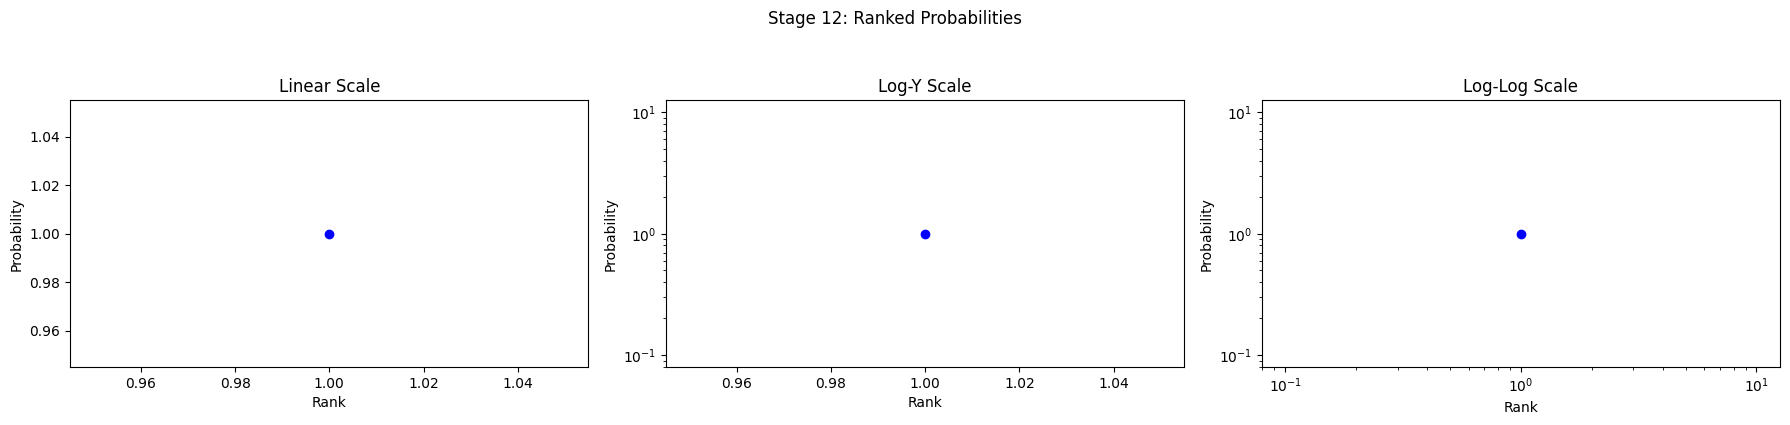

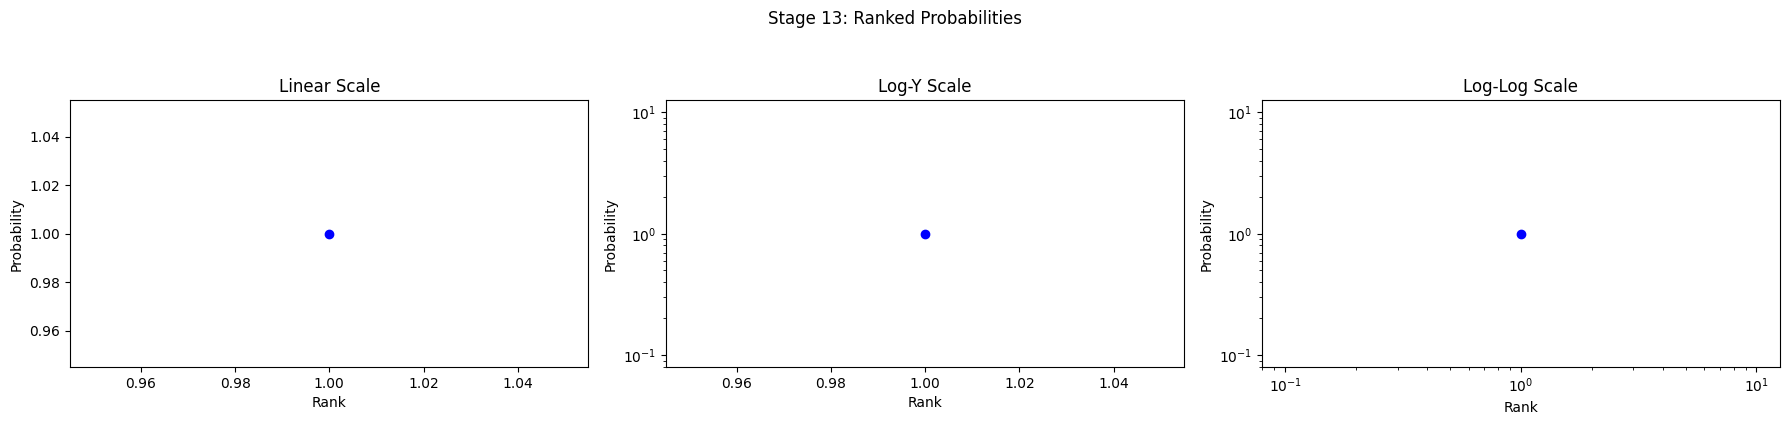

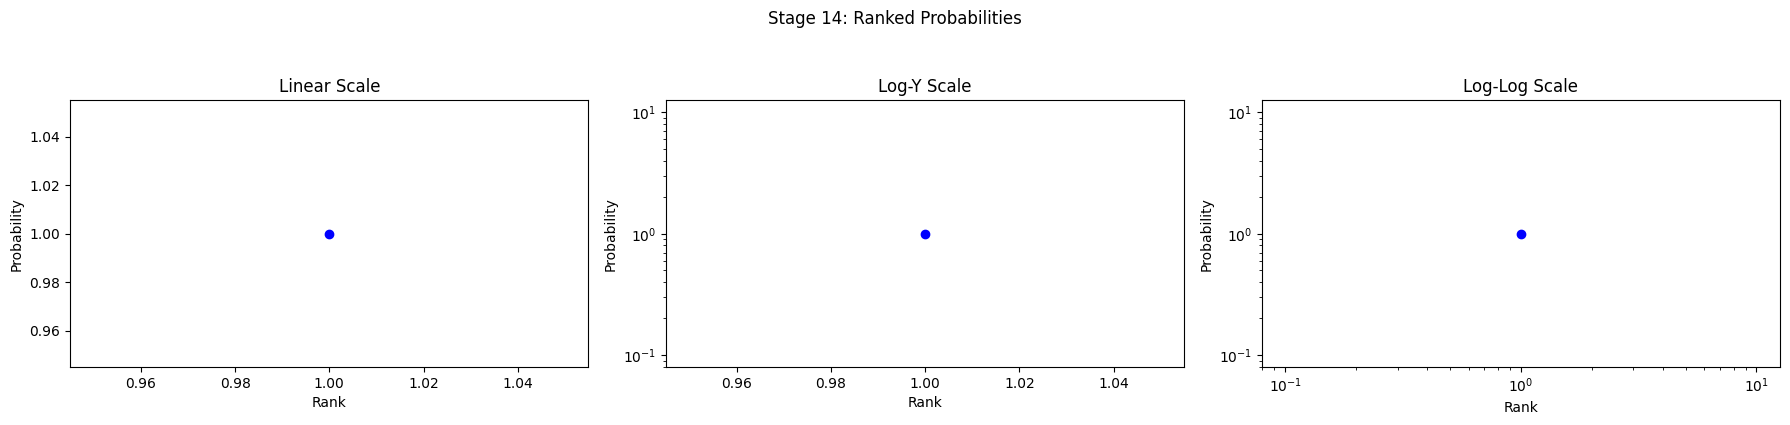

Reverse starts here


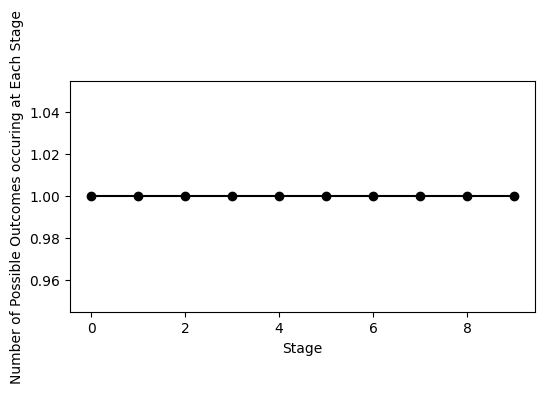

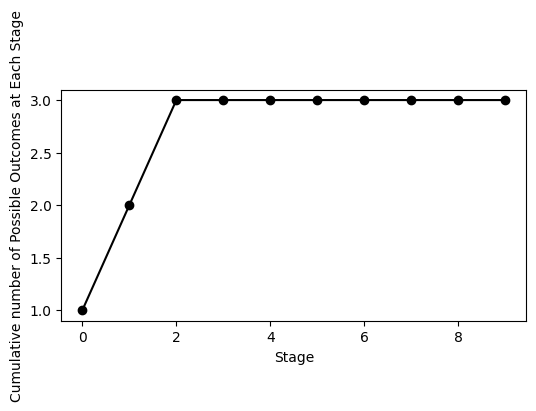

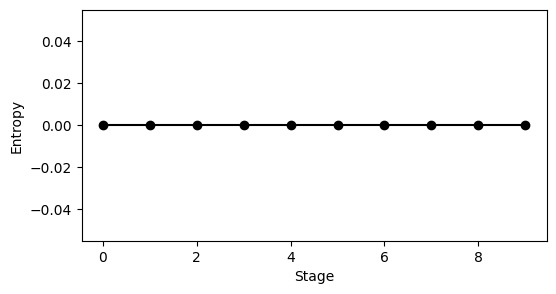

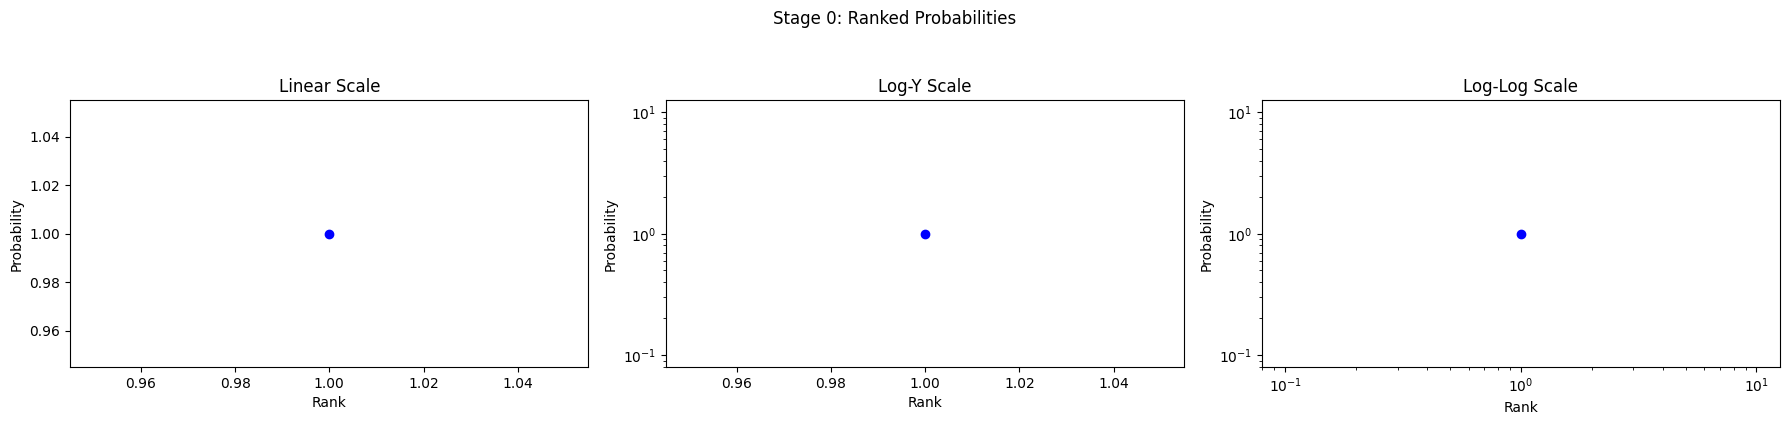

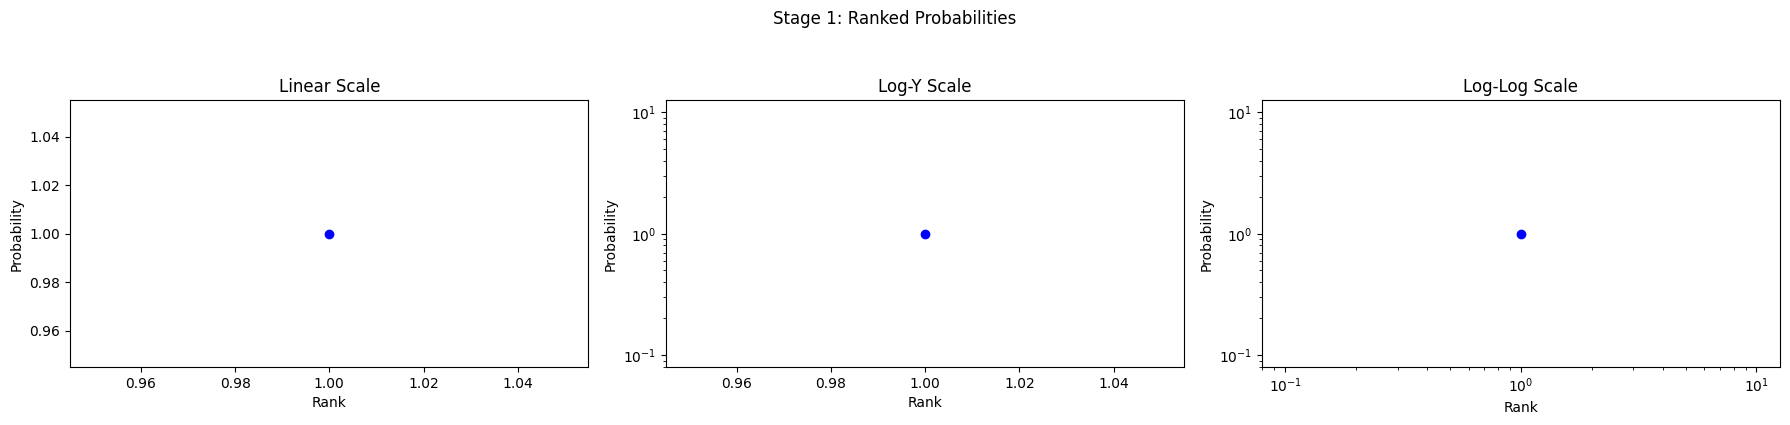

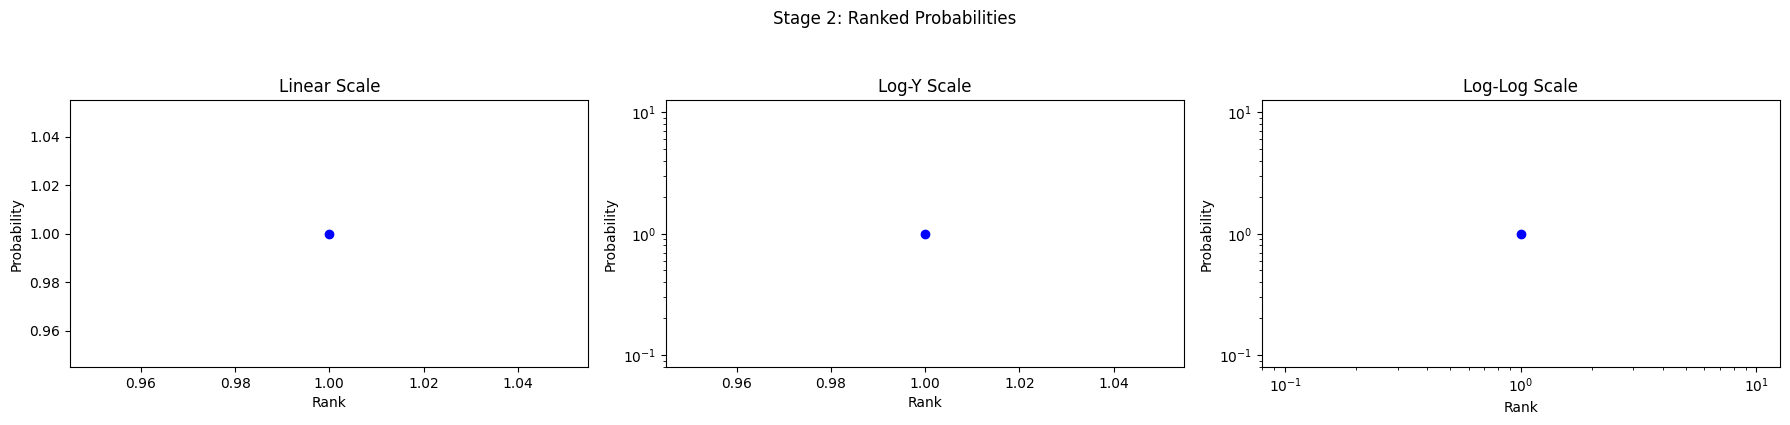

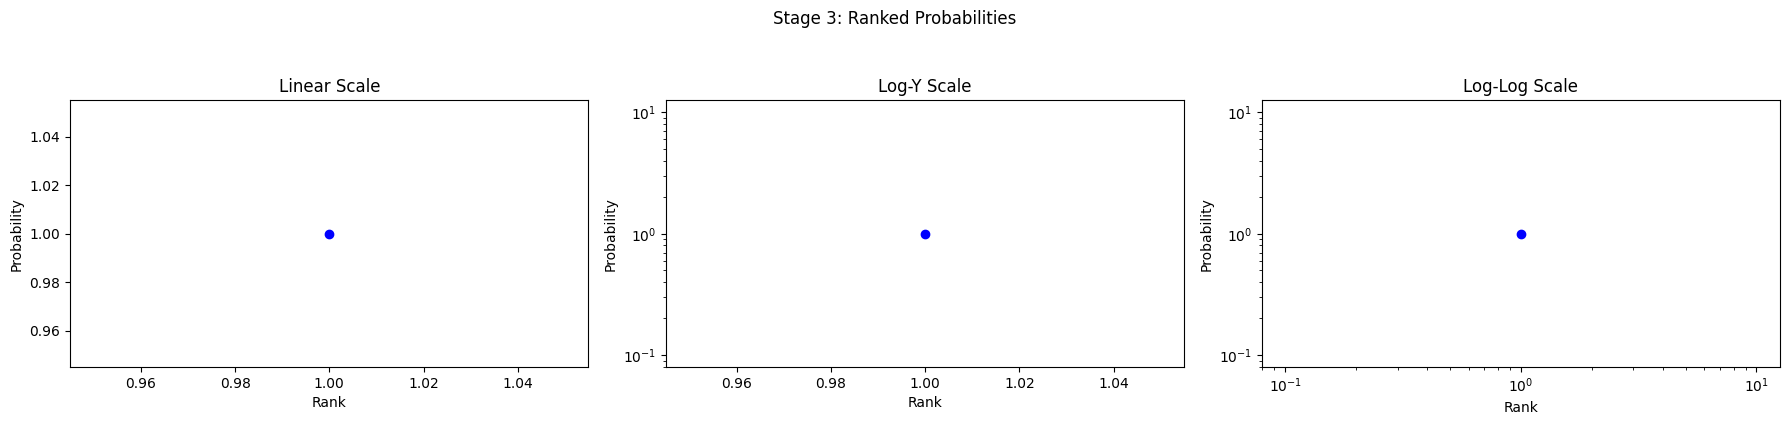

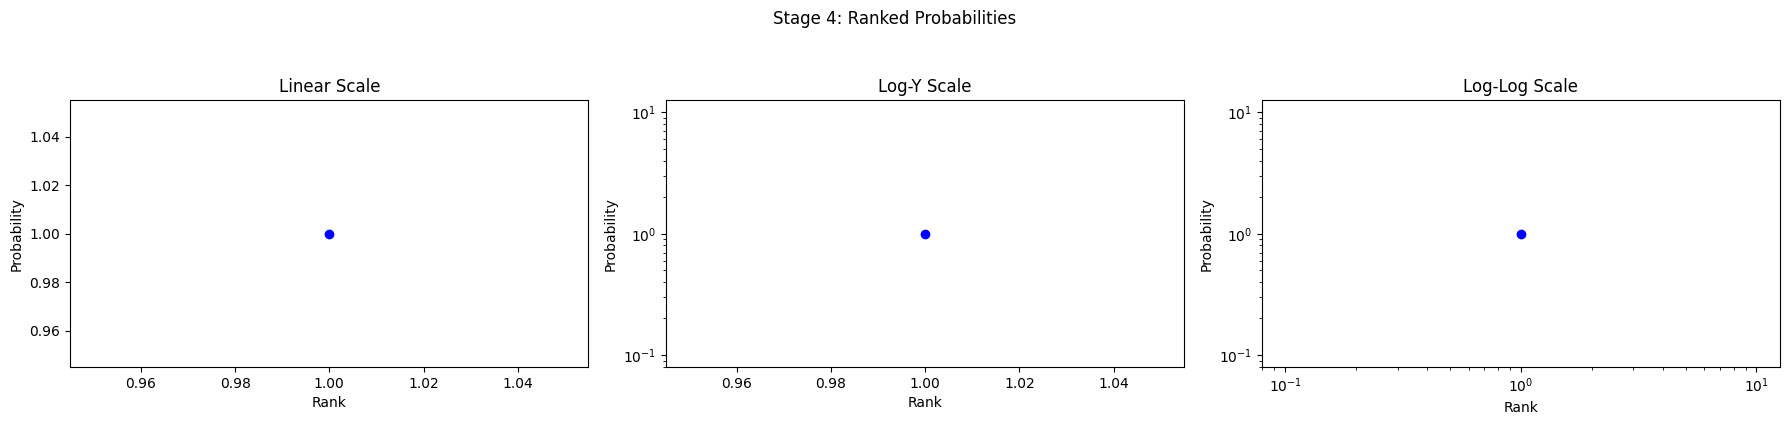

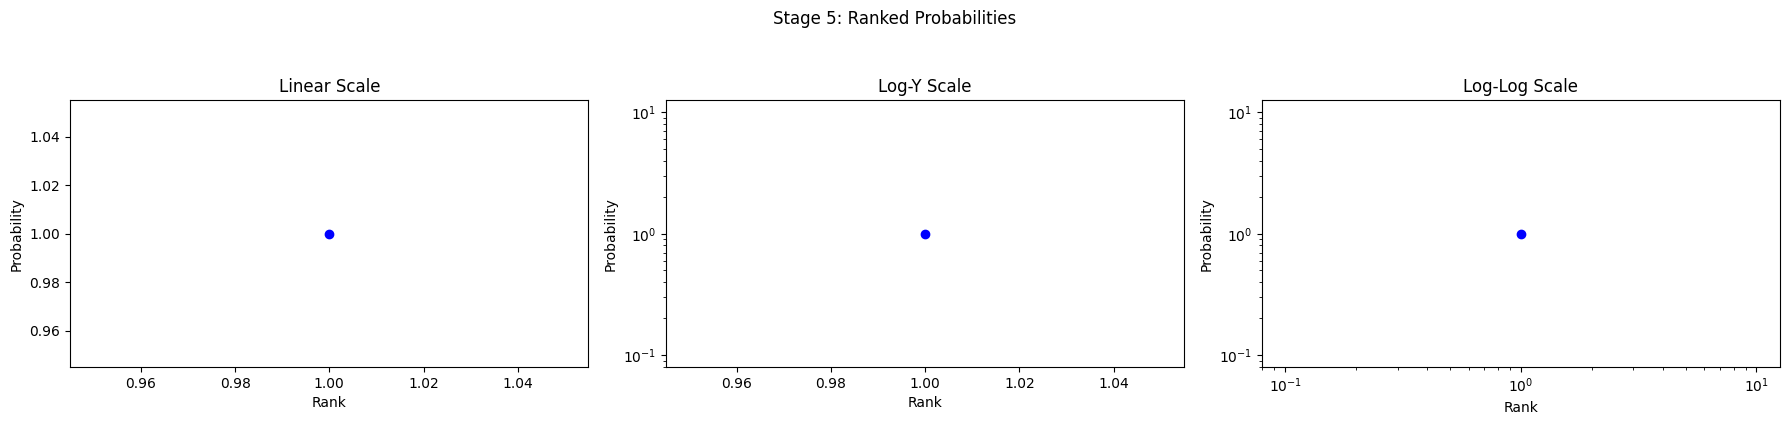

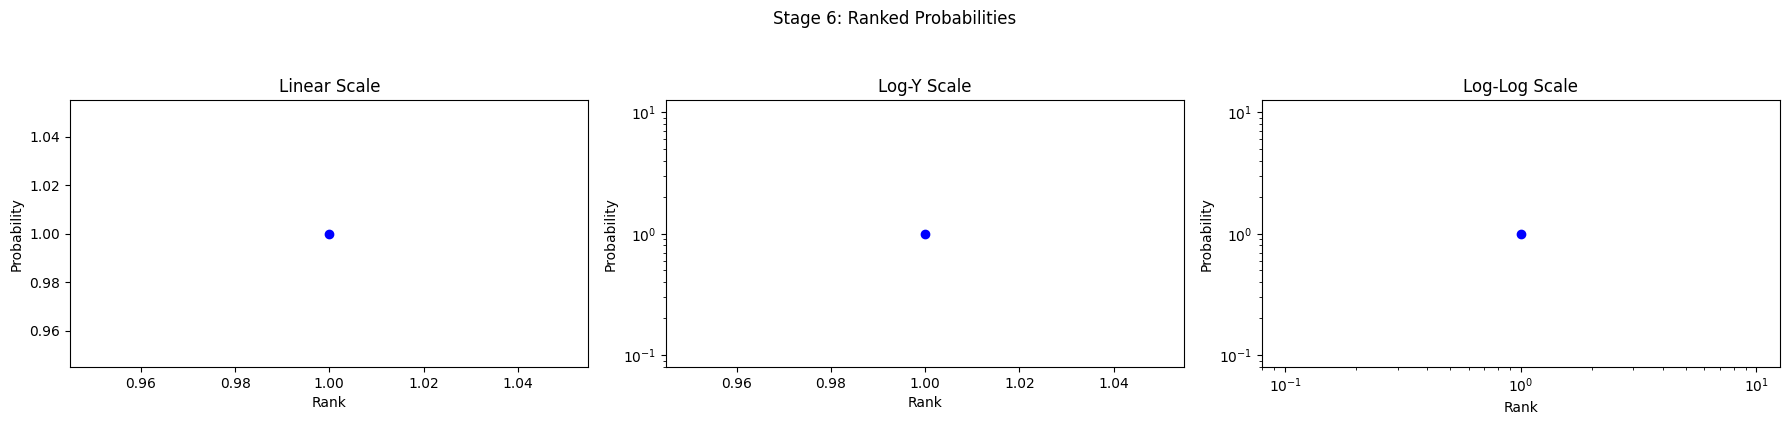

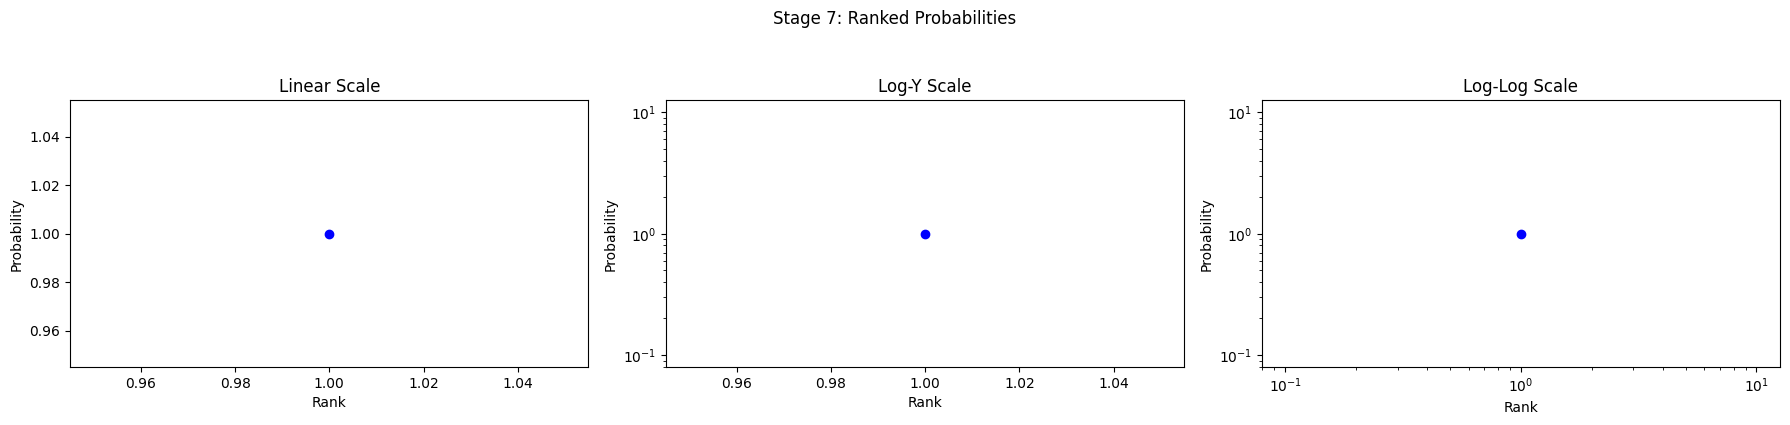

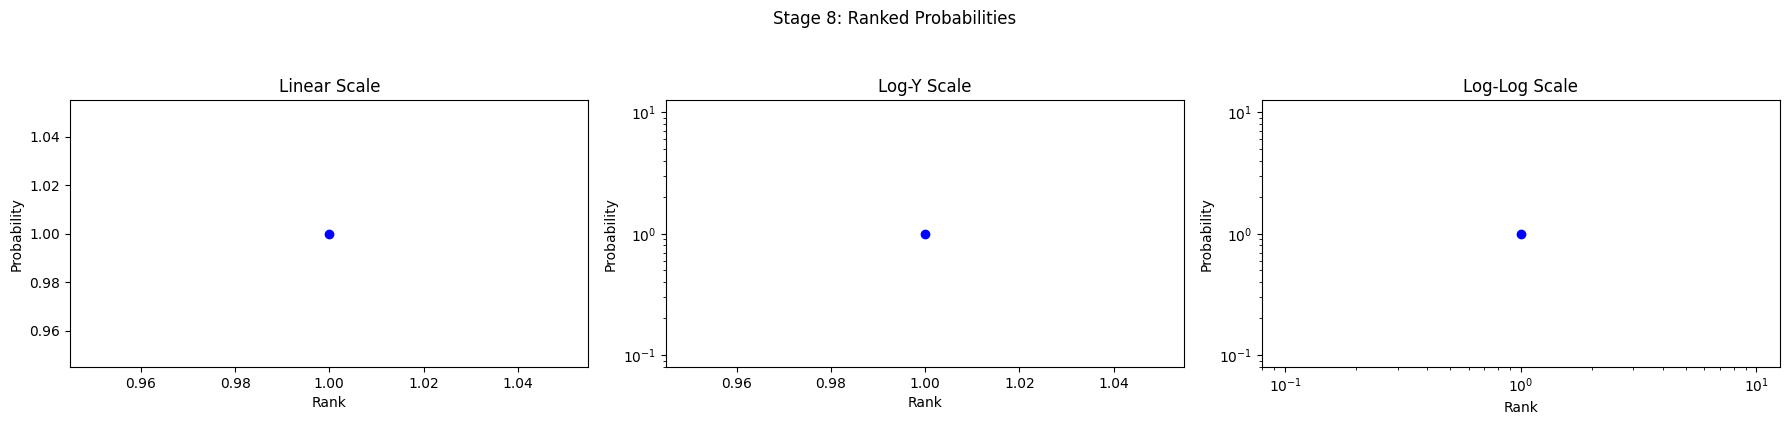

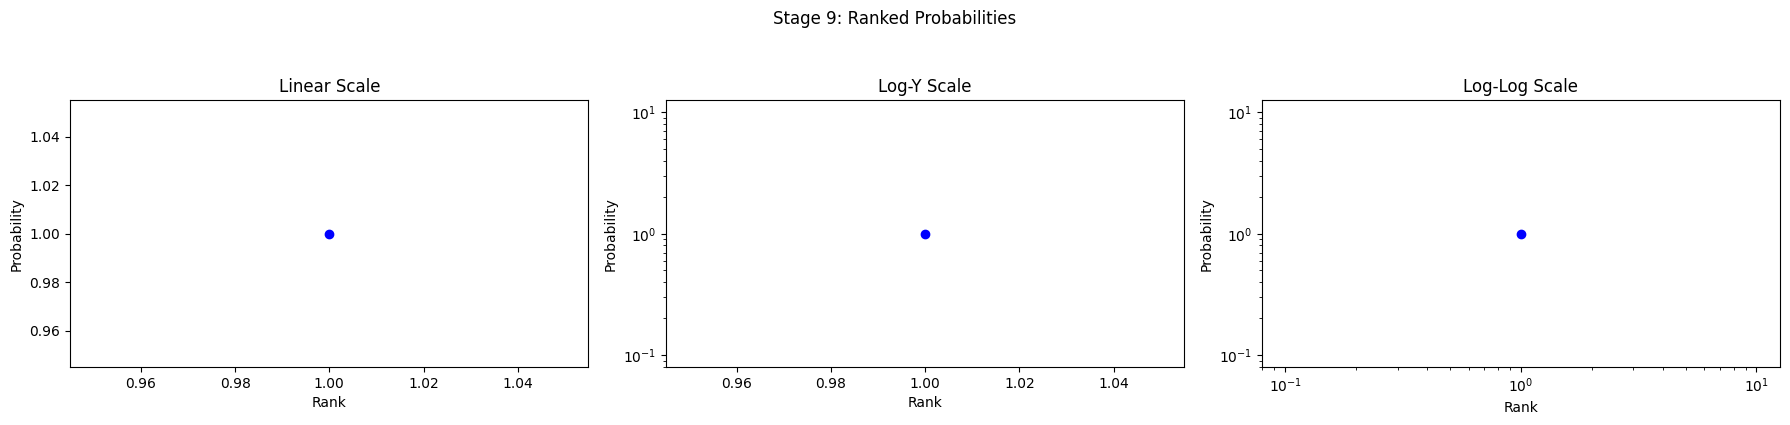

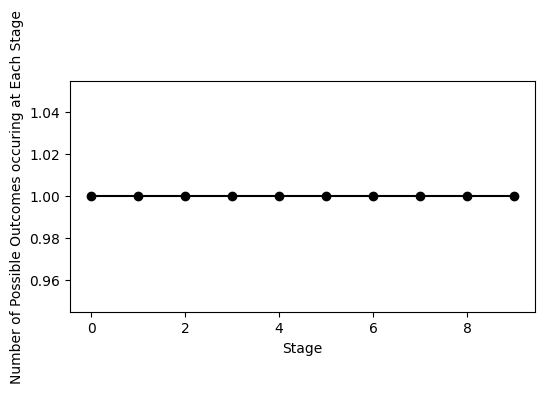

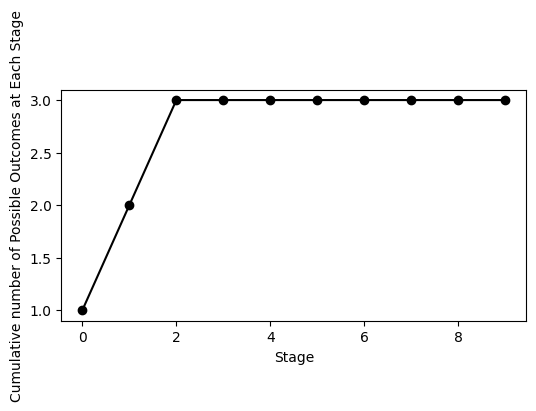

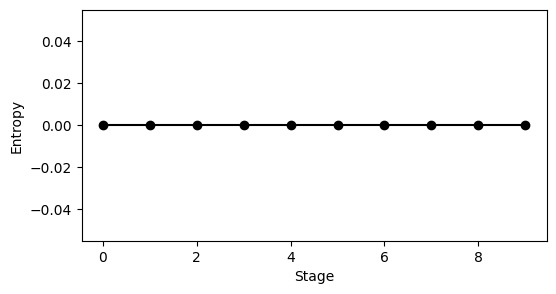

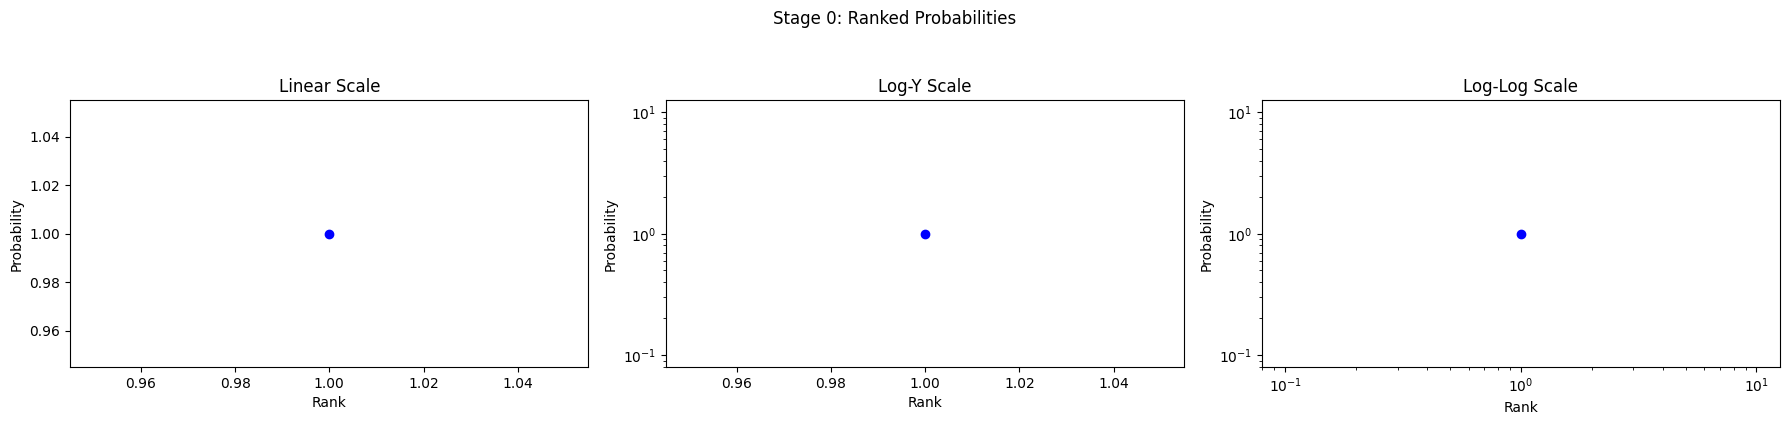

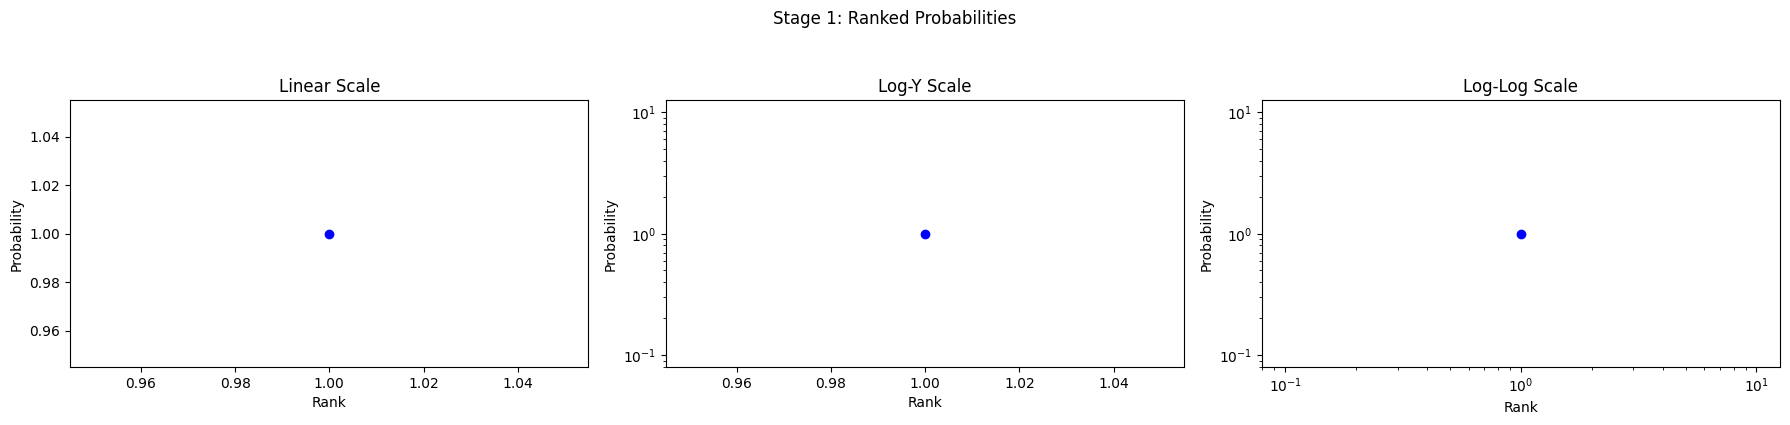

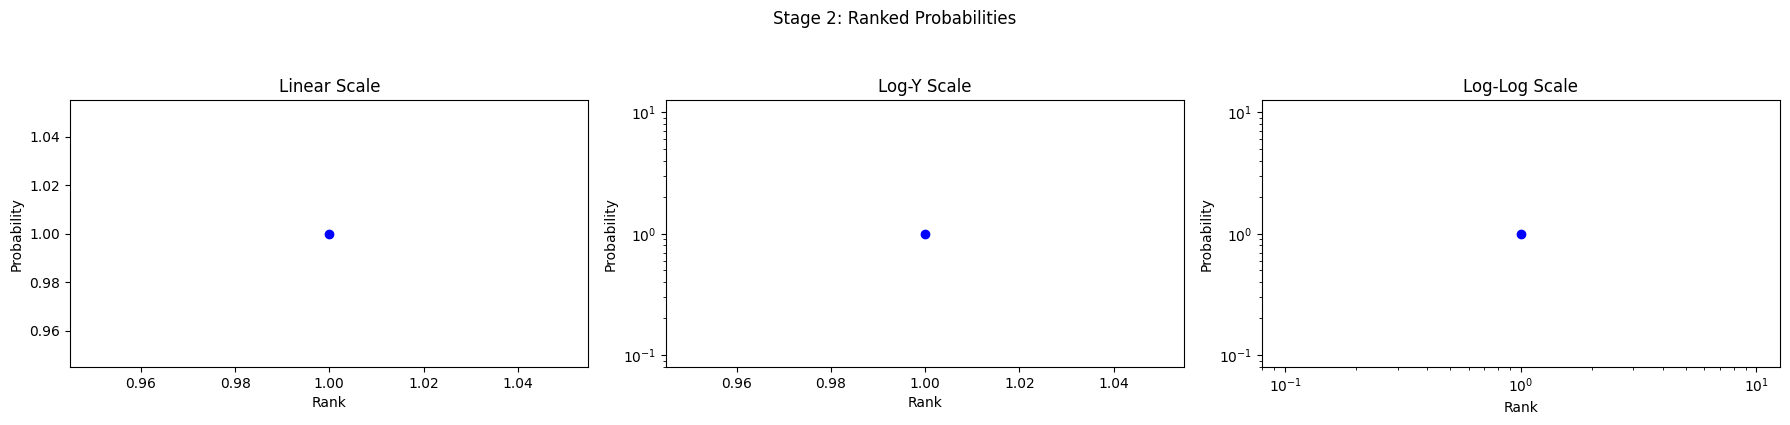

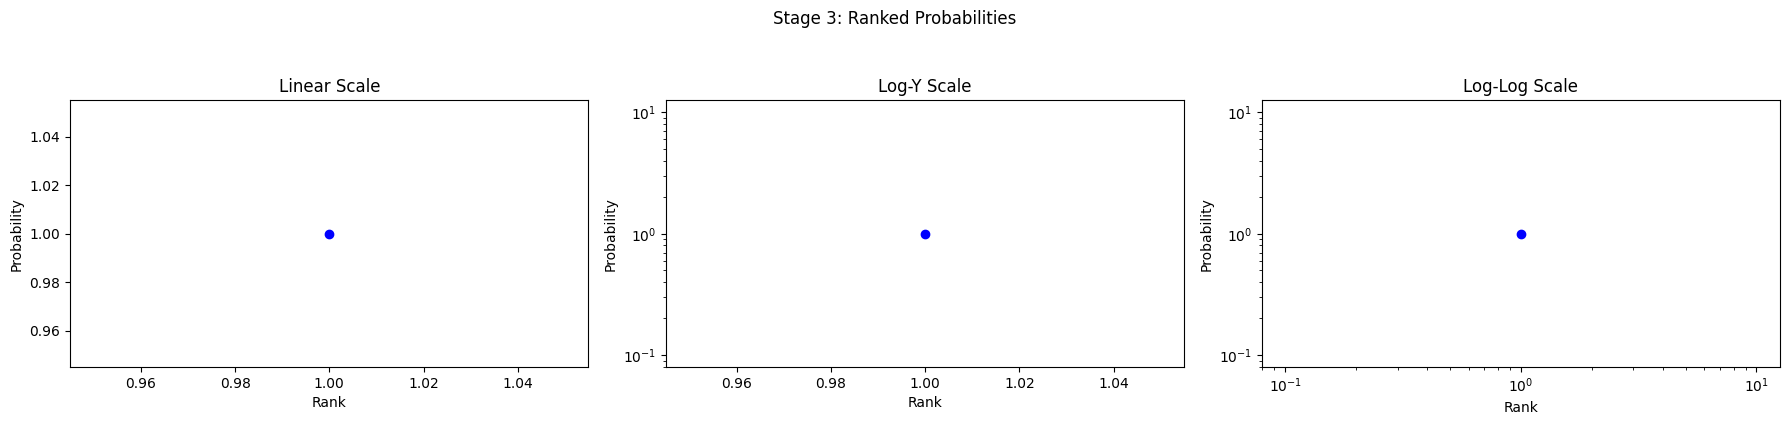

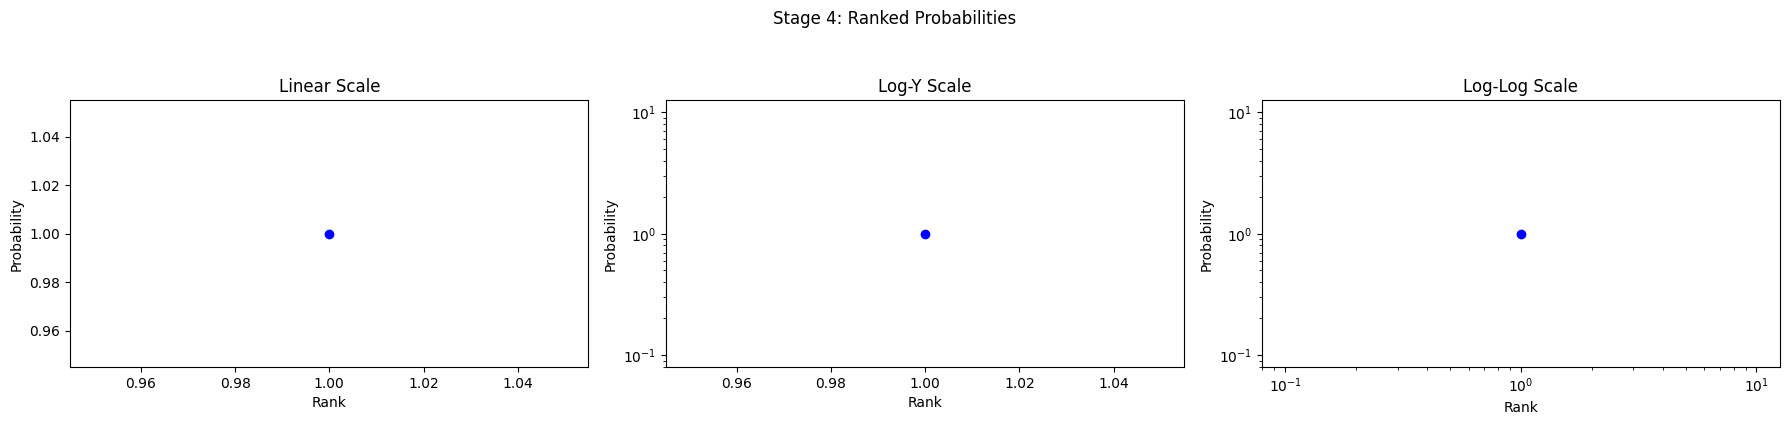

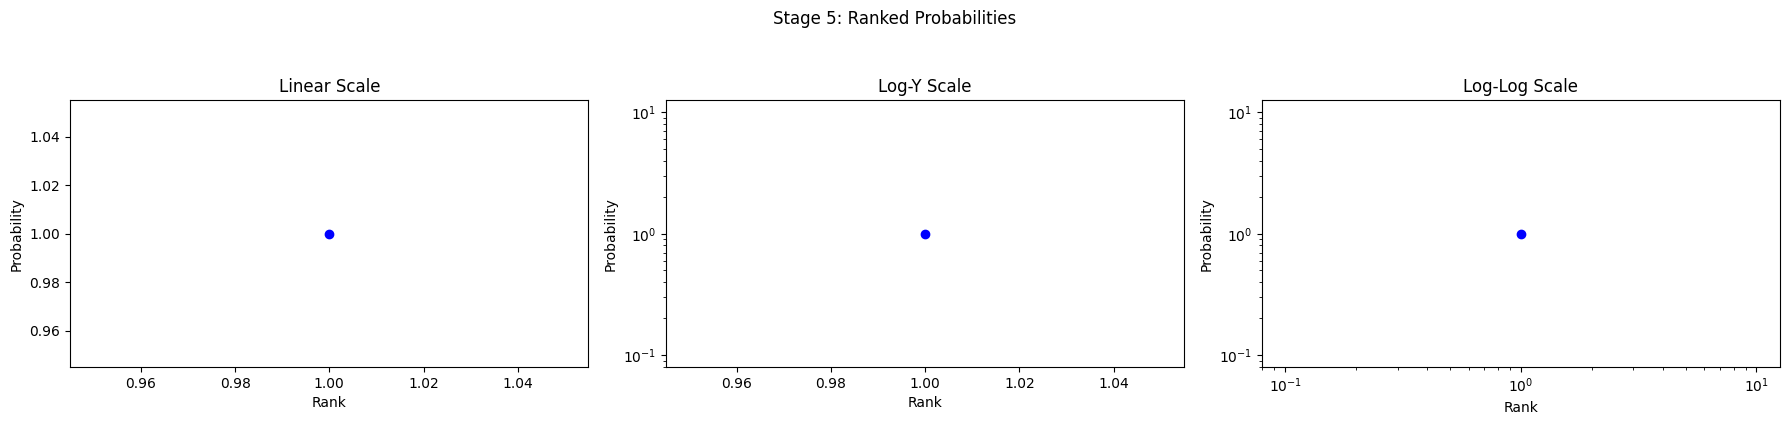

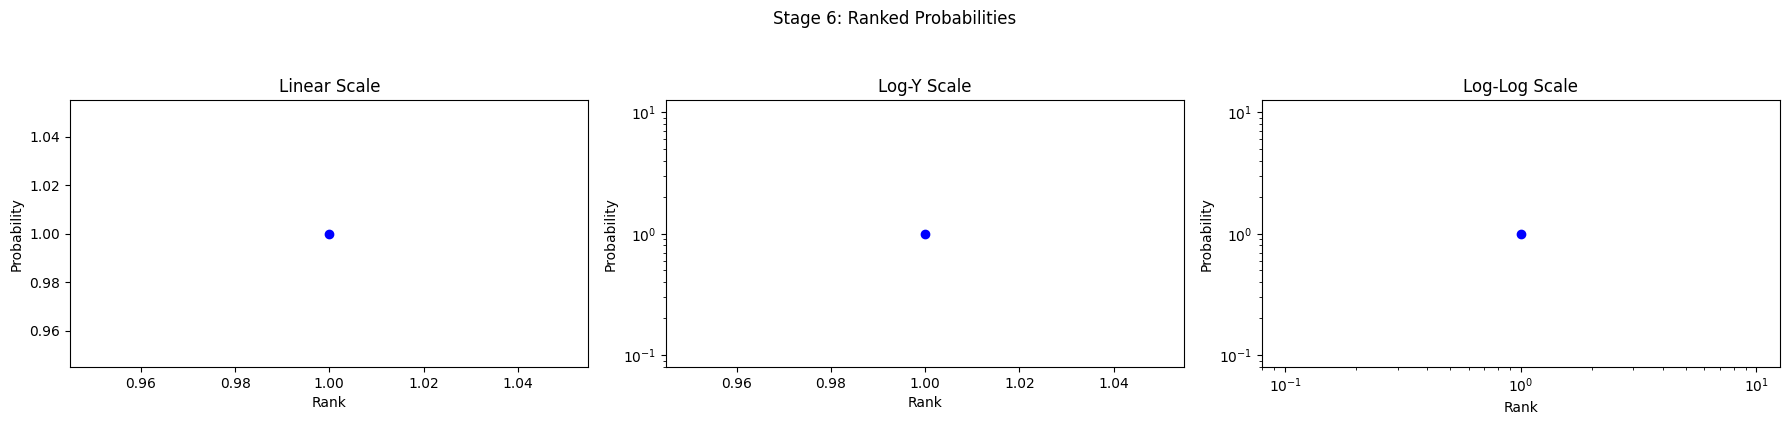

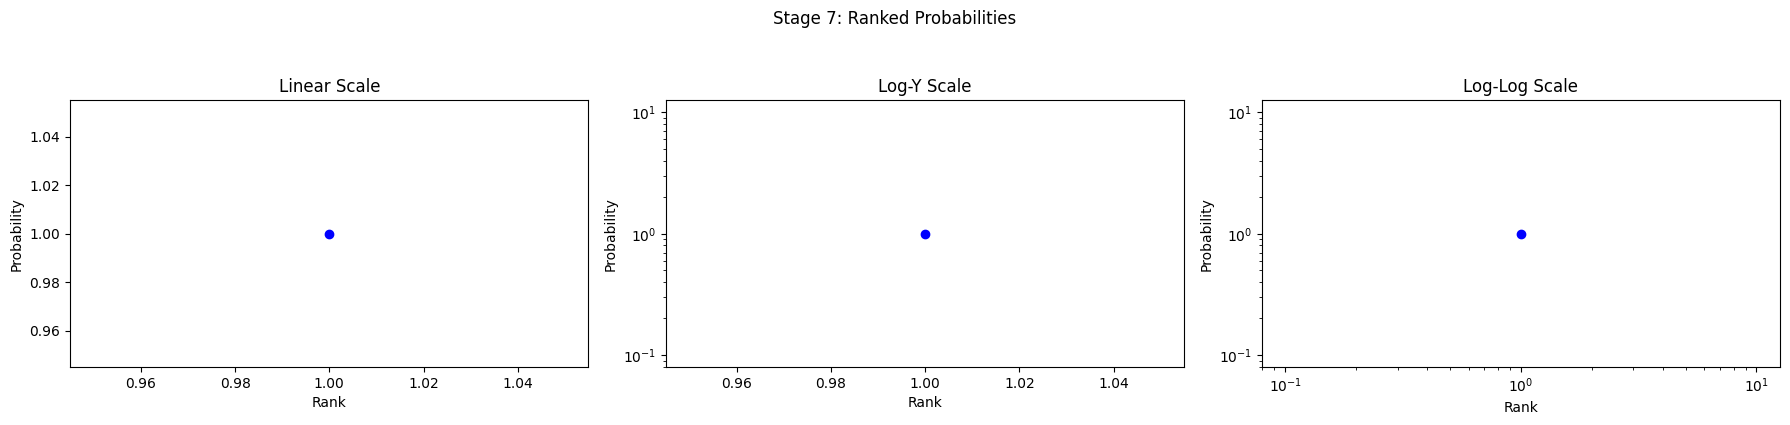

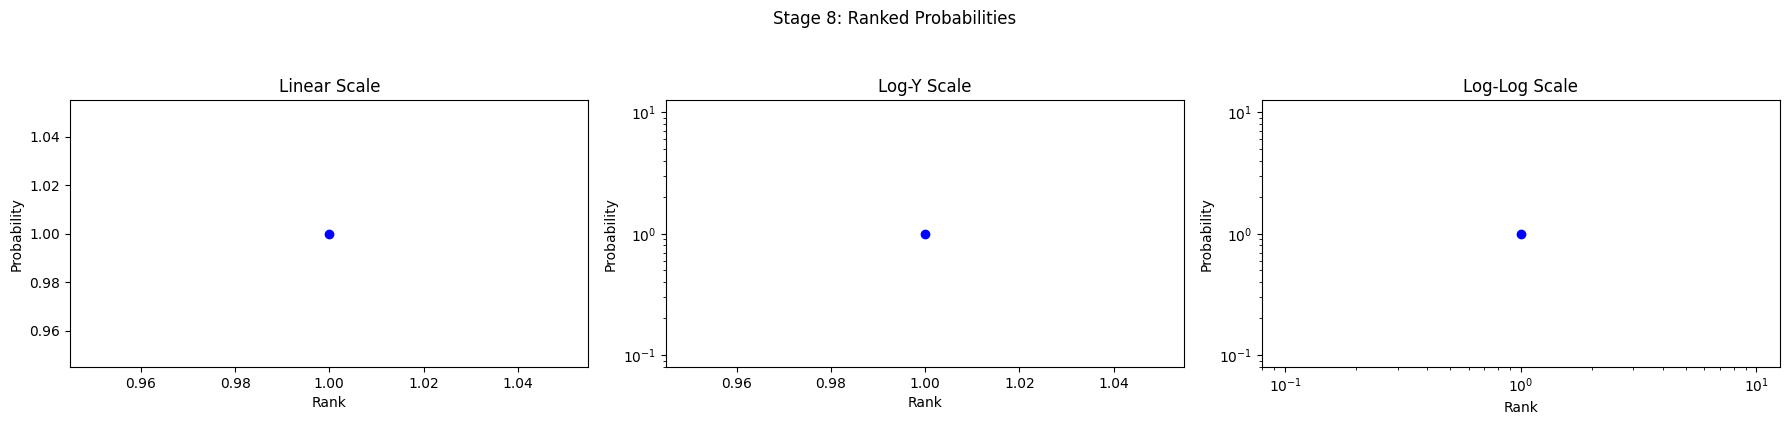

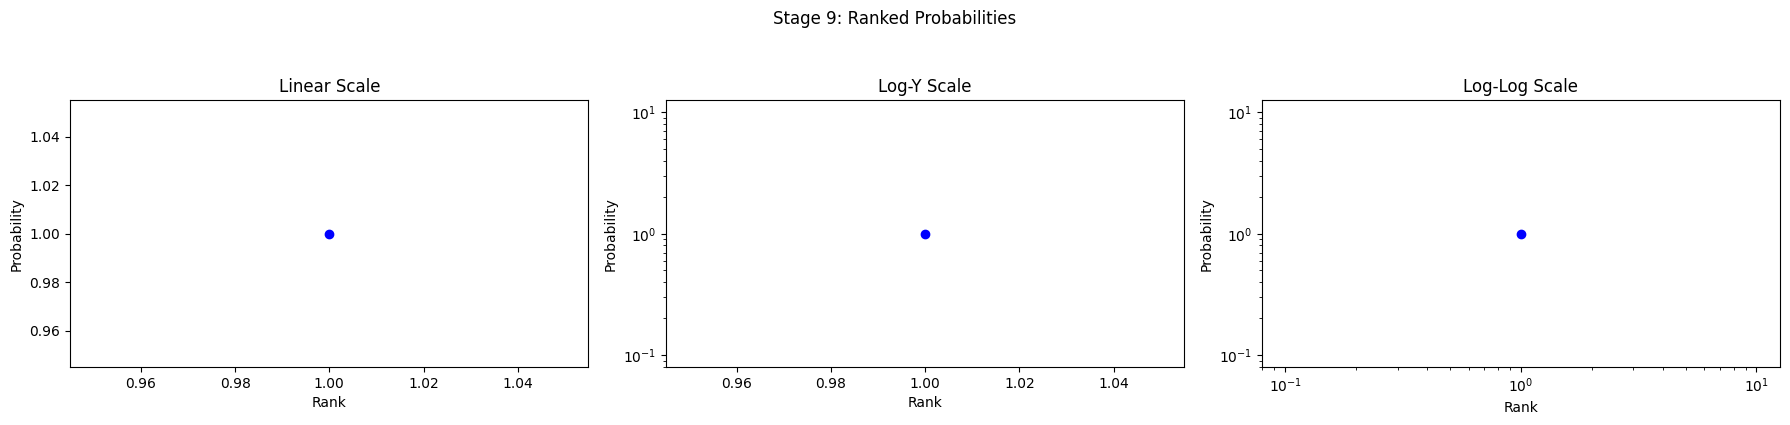

In [35]:
#Sequence with single active site
DNA_sequence=[
#'1', 'A', 'ALPHA',
#'2','A','ALPHA',
'3', 'A', 'ALPHA',
'4', 'A', 'GAMMA',
'5','beta', 'b',
#'6','beta', 'b',
#'7','beta', 'b',

]
pairs_pool=[(['A','GAMMA'],['B','BETA']),(['A','ALPHA'],['B','GAMMA'])]
outcome_lists_1= run_probability_calculation_and_plot_IS110(DNA_sequence,pairs_pool,numberofevents=15,plot=1,rank=1)

print("Reverse starts here")
for i in range(1):
    DNA_sequence_2 = list(random.choice(list(outcome_lists_1[-1].keys())))
    pairs_pool_2=[(['A','GAMMA'],['B','ALPHA']),(['B','GAMMA'],['A','BETA'])]
    outcome_lists_2= run_probability_calculation_and_plot_IS110(DNA_sequence_2,pairs_pool_2,numberofevents=10, plot=1,rank=1)


DNA_sequence_3 = list(random.choice(list(outcome_lists_2[-1].keys())))
pairs_pool_3=[(['A','GAMMA'],['B','BETA']),(['B','GAMMA'],['A','ALPHA'])]
outcome_lists_3= run_probability_calculation_and_plot_IS110(DNA_sequence_3,pairs_pool_3,numberofevents=10, plot=1,rank=1)


c:\Users\Thoma\anaconda3\envs\rstudio\lib\site-packages\numba\core\ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'DNA' of function 'delete_between'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\AppData\Local\Temp\ipykernel_20320\1589055869.py", line 2:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


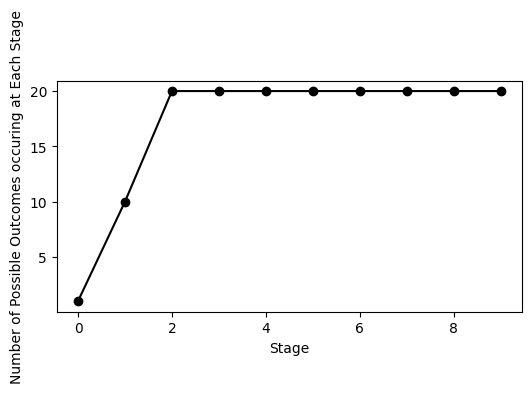

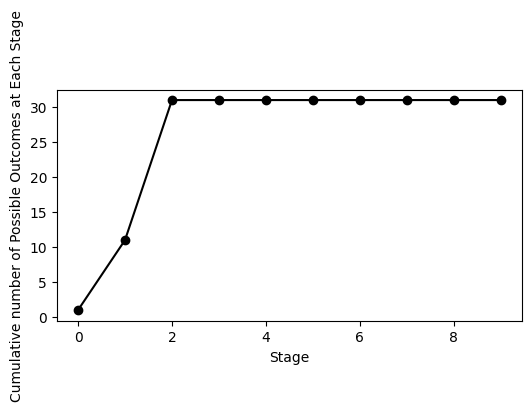

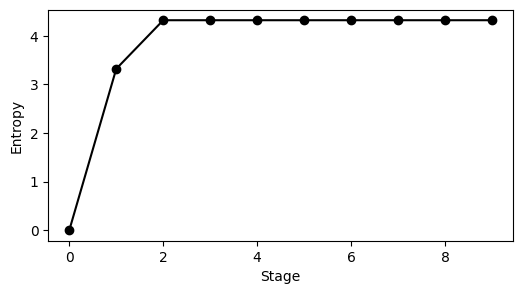

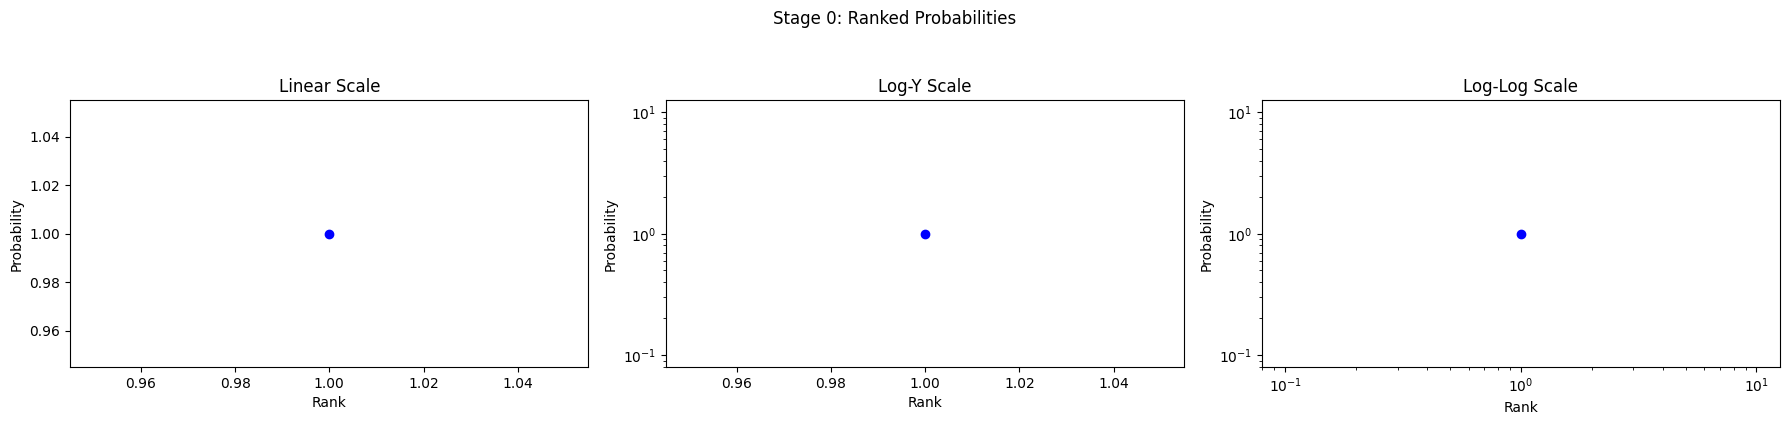

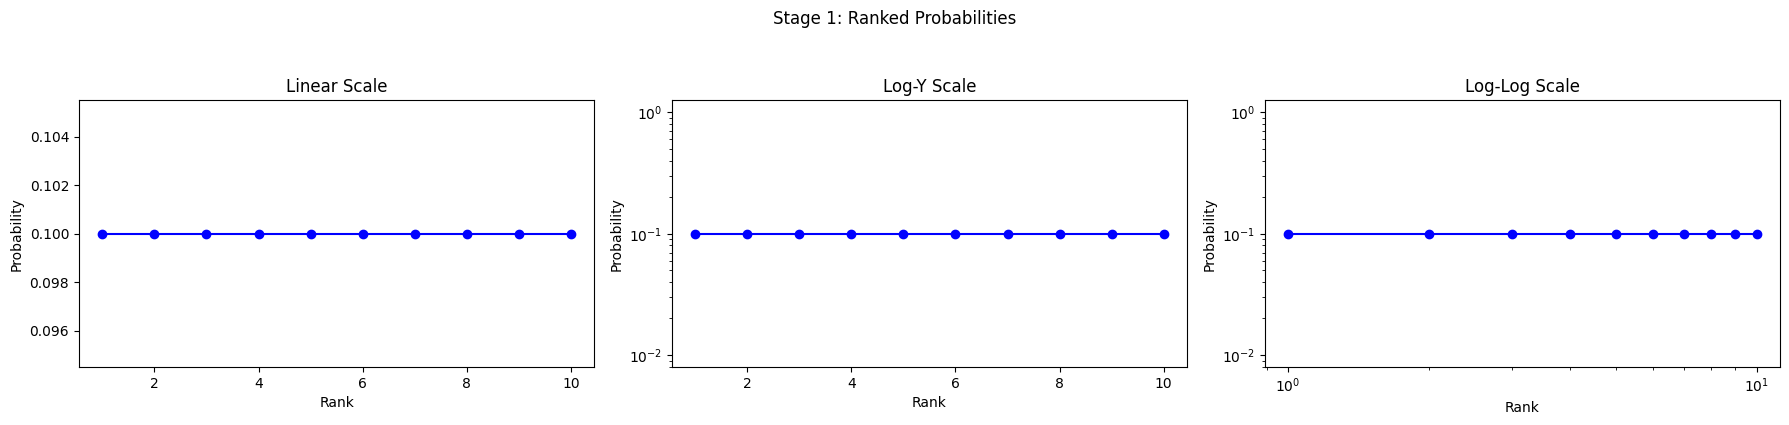

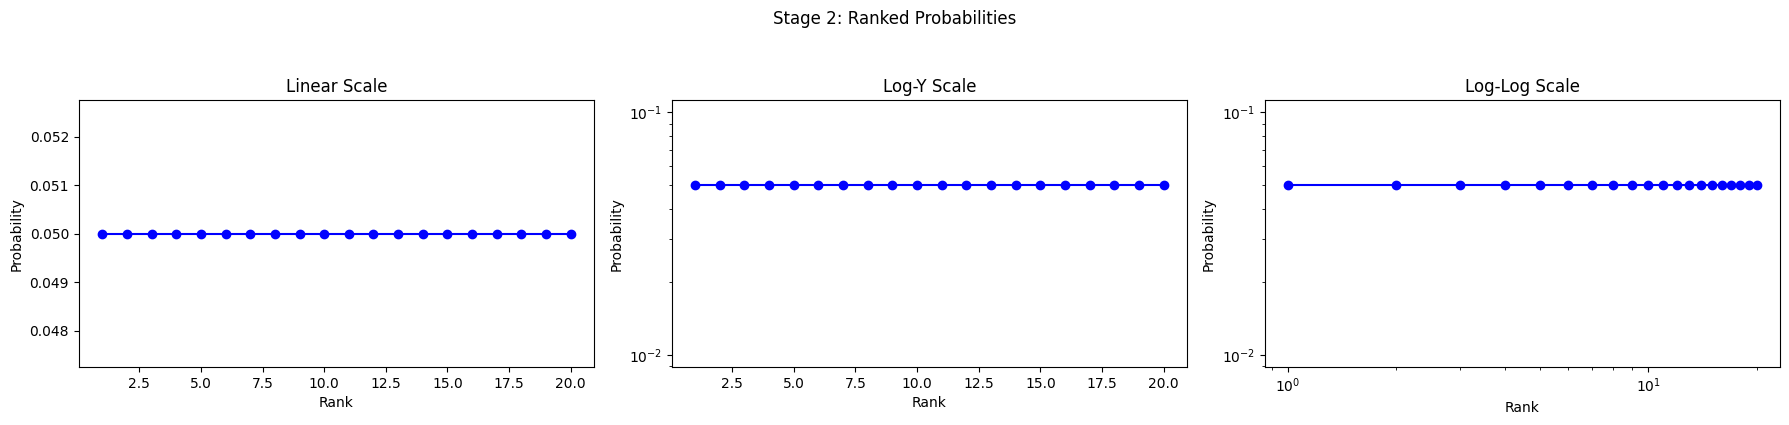

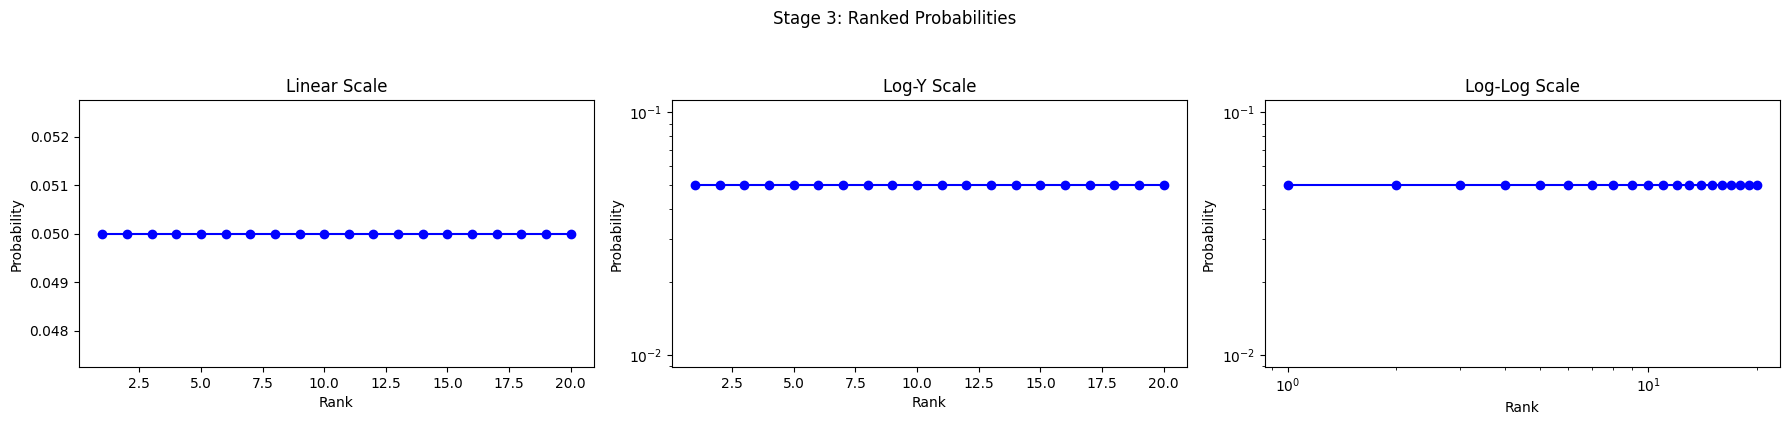

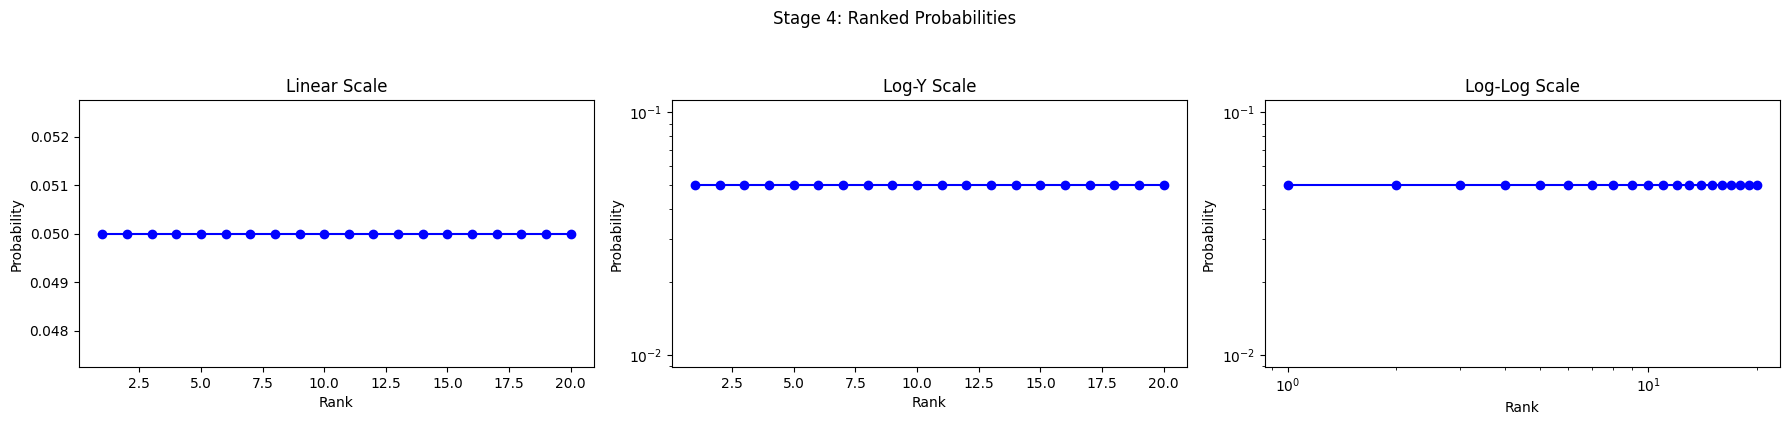

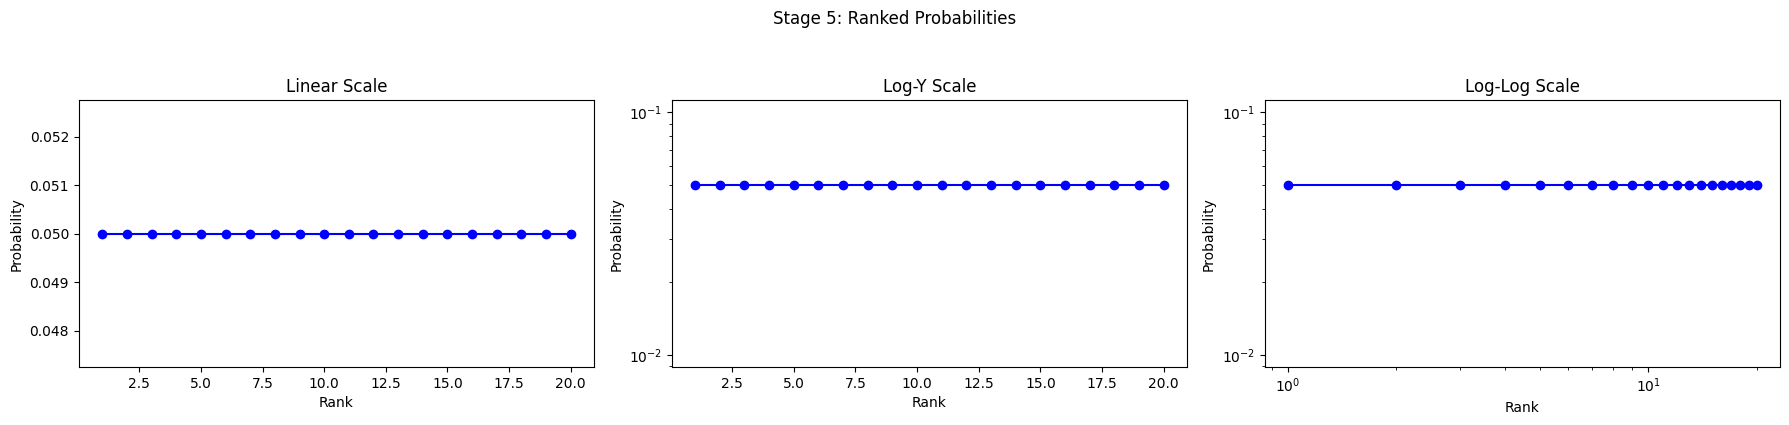

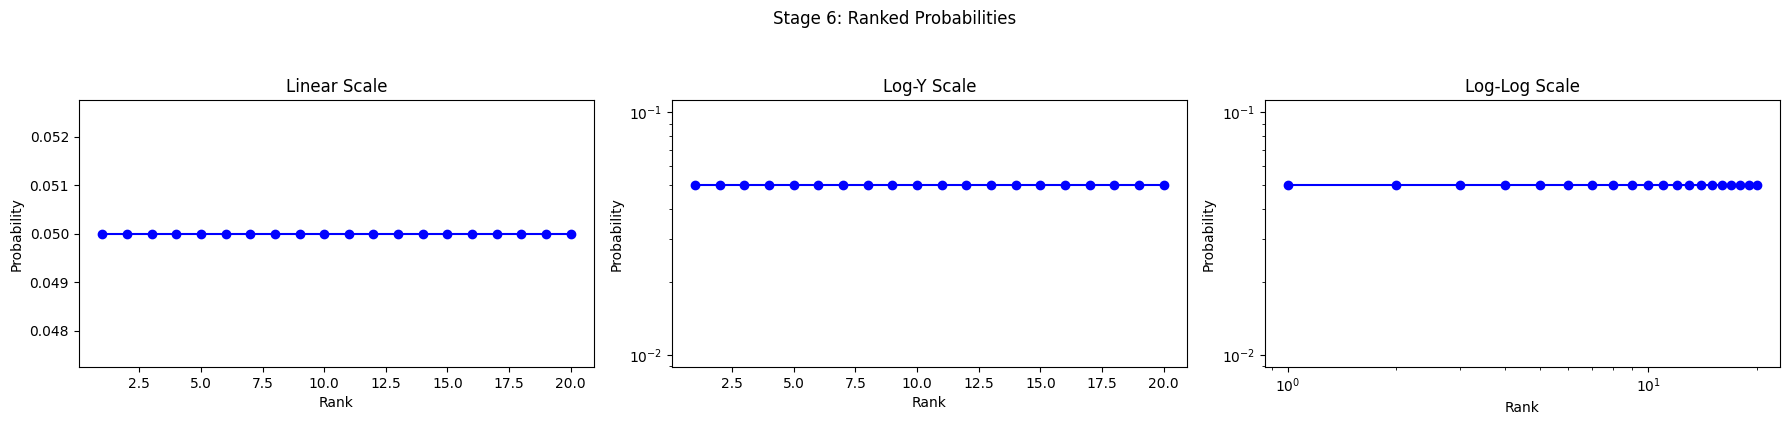

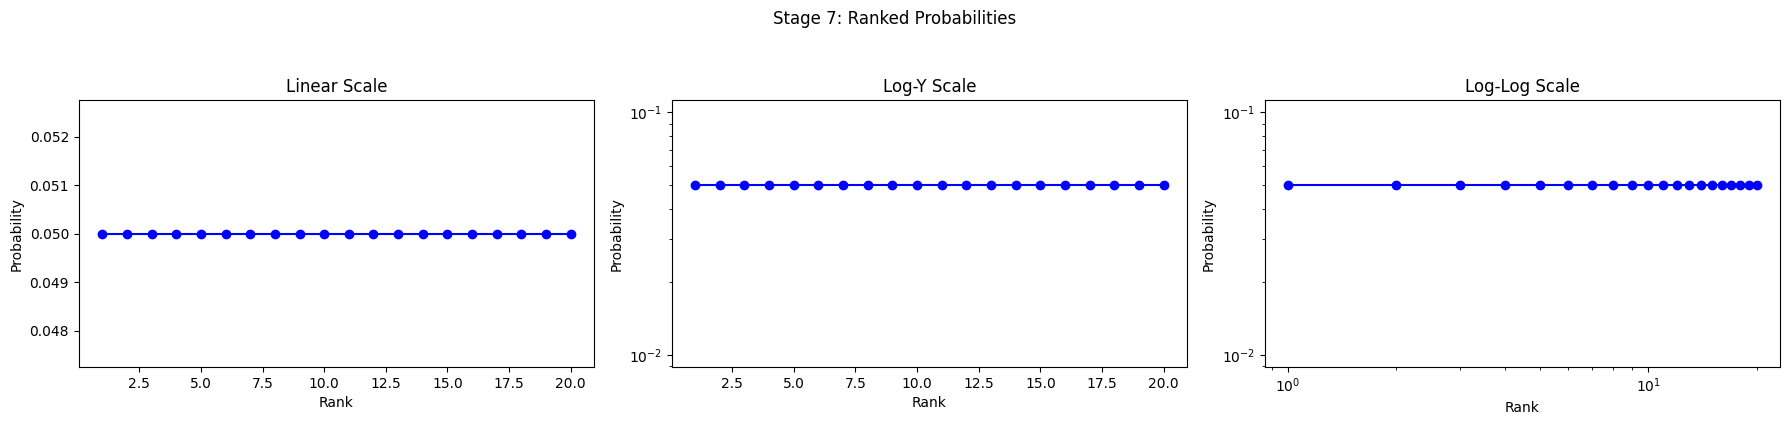

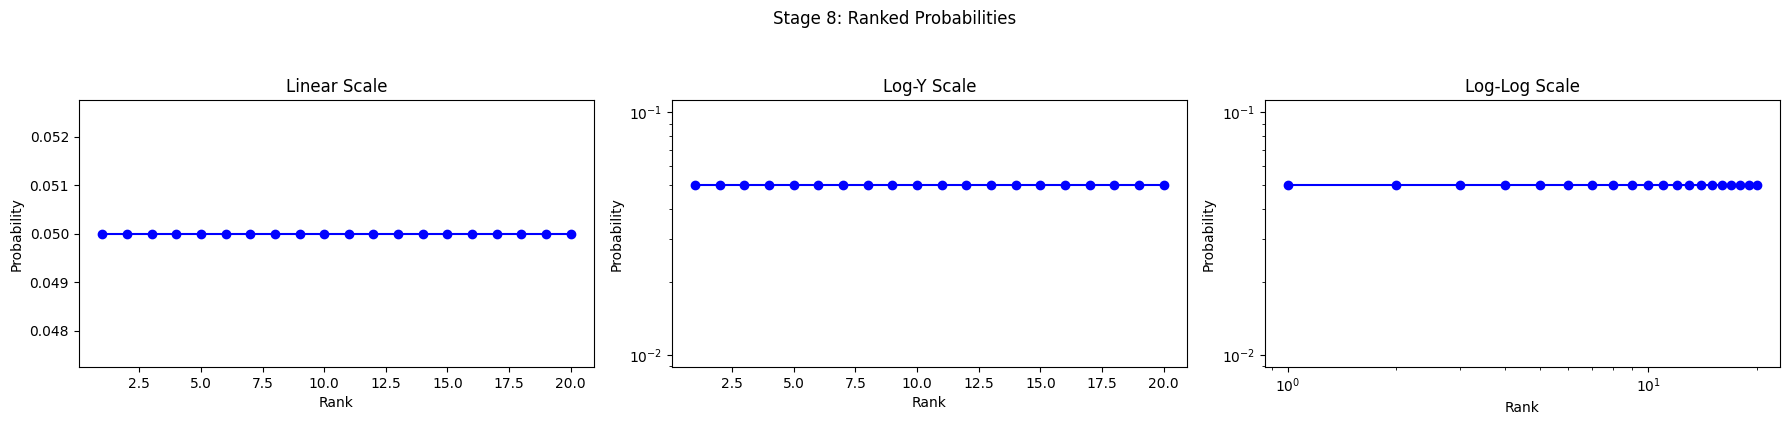

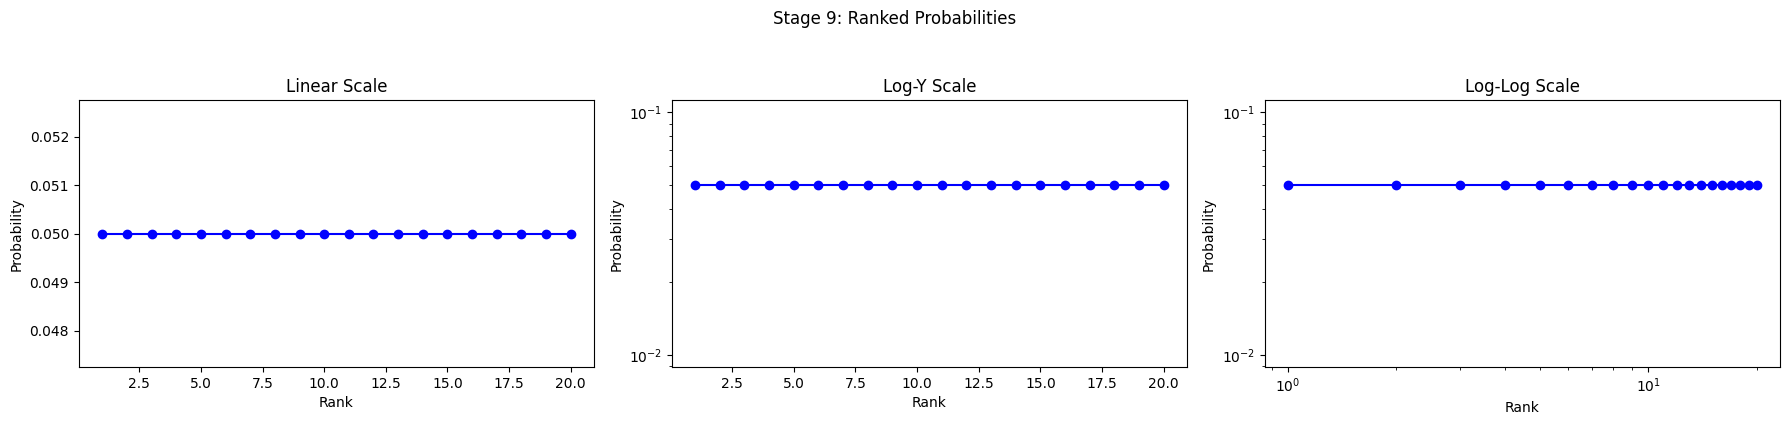

In [36]:
#An attempt of reversable sequence
DNA_sequence=[
#'1', 'A', 'ALPHA',
'2','A','ALPHA',
'3', 'A', 'ALPHA',
'4', 'beta', 'b',
'5','gamma', 'c',
'6','delta', 'd',
'7','epsilon', 'e',
'8','zeta', 'f'
]
pairs_pool=[(['A','ALPHA'],['B','BETA']),(['A','ALPHA'],['C','GAMMA']),(['A','ALPHA'],['D','DELTA']),(['A','ALPHA'],['E','EPSILON']),(['A','ALPHA'],['F','ZETA'])]
outcome_lists= run_probability_calculation_and_plot_IS110(DNA_sequence,pairs_pool,numberofevents=10,plot=1,rank=1)